In [1]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from cmdstanpy import CmdStanModel
import cmdstanpy
import arviz as az
import pandas as pd
import csv,re

from DA_tools.DA_tools import ribbon_plot
from DA_tools.FDA_data_prepare import create_spline_matrix
from DA_tools.DA_colors import *

plt.style.context("seaborn-white")
mpl.rcParams["figure.dpi"] = 200

In [3]:
LIGHT = "#B3FFFF"  # 179, 255, 255,
LIGHT_HIGHLIGHT = "#9AF6FF"  # 154, 246,255
MID = "#67C3FF"  # 103,195,255
MID_HIGHLIGHT = "#3490CC"  # 52,144,204
DARK = "#015D99"  # 1,93,153
DARK_HIGHLIGHT = "#002A66"  # 0,42,102
GREEN = "#00FF00"  # RGB
LIGHT_GREY = "#DDDDDD"  # RGB

In [4]:
acc_healthy = pd.read_csv('data_preprocesed/acc_healthy_samples.csv')
acc_damaged = pd.read_csv('data_preprocesed/acc_damaged_samples.csv')
acc_very_damaged = pd.read_csv('data_preprocesed/acc_very_damaged_samples.csv')

gyro_healthy = pd.read_csv('data_preprocesed/gyro_healthy_samples.csv')
gyro_damaged = pd.read_csv('data_preprocesed/gyro_damaged_samples.csv')
gyro_very_damaged = pd.read_csv('data_preprocesed/gyro_very_damaged_samples.csv')

gyro_agg_healthy = pd.read_csv('data_preprocesed/gyro_agg_healthy_samples.csv')
gyro_agg_damaged = pd.read_csv('data_preprocesed/gyro_agg_damaged_samples.csv')
gyro_agg_very_damaged = pd.read_csv('data_preprocesed/gyro_agg_very_damaged_samples.csv')

In [5]:
acc_healthy_data = np.array([acc_healthy[col].values for col in acc_healthy.columns if col.startswith('Sample')])
acc_damaged_data = np.array([acc_damaged[col].values for col in acc_damaged.columns if col.startswith('Sample')])
acc_v_damaged_data = np.array([acc_very_damaged[col].values for col in acc_very_damaged.columns if col.startswith('Sample')])
acc = [acc_healthy_data,acc_damaged_data,acc_v_damaged_data]

gyro_healthy_data = np.array([gyro_healthy[col].values for col in gyro_healthy.columns if col.startswith('Sample')])
gyro_damaged_data = np.array([gyro_damaged[col].values for col in gyro_damaged.columns if col.startswith('Sample')])
gyro_very_damaged_data = np.array([gyro_very_damaged[col].values for col in gyro_very_damaged.columns if col.startswith('Sample')])
gyro = [gyro_healthy_data,gyro_damaged_data,gyro_very_damaged_data]

gyro_agg_healthy_data = np.array([gyro_agg_healthy[col].values for col in gyro_agg_healthy.columns if col.startswith('Sample')])
gyro_agg_damaged_data = np.array([gyro_agg_damaged[col].values for col in gyro_agg_damaged.columns if col.startswith('Sample')])
gyro_agg_very_damaged_data = np.array([gyro_agg_very_damaged[col].values for col in gyro_agg_very_damaged.columns if col.startswith('Sample')])
gyro_agg = [gyro_agg_healthy_data,gyro_agg_damaged_data,gyro_agg_very_damaged_data]

Prior predictive check

In [6]:
prior_model_1 = CmdStanModel(stan_file='stan/prior_check.stan')

01:42:04 - cmdstanpy - INFO - compiling stan file /Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/prior_check.stan to exe file /Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/prior_check
01:42:09 - cmdstanpy - INFO - compiled model executable: /Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/prior_check


In [7]:
num_knots = 15
N = 150
frequencies = None
if frequencies is None:
    times = np.linspace(0,N*10,N)
    knot_list = np.quantile(times,np.linspace(0,1,num_knots))
    B0 = create_spline_matrix(N, times, 3, num_knots)

else:
    knot_list = np.quantile(frequencies,np.linspace(0,1,num_knots))
    B0 = create_spline_matrix(N, frequencies, 3, num_knots)
data_ppc = {
    "N": N,
    "K": num_knots+2,
    "X": B0
}
ppc_samples = prior_model_1.sample(data=data_ppc)

01:42:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

01:42:09 - cmdstanpy - INFO - CmdStan done processing.


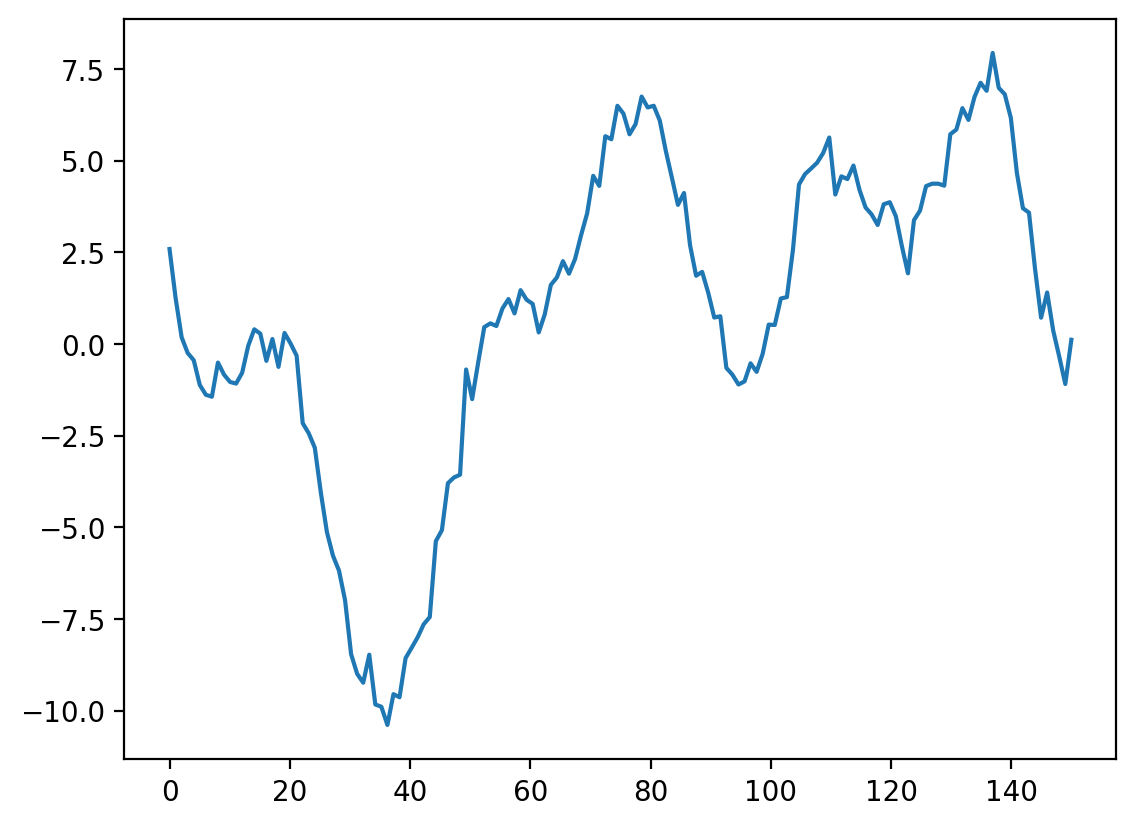

In [8]:
sample_1 = ppc_samples.stan_variable('y_pred')[1]
x = np.linspace(0,150,N)
plt.plot(x,sample_1)

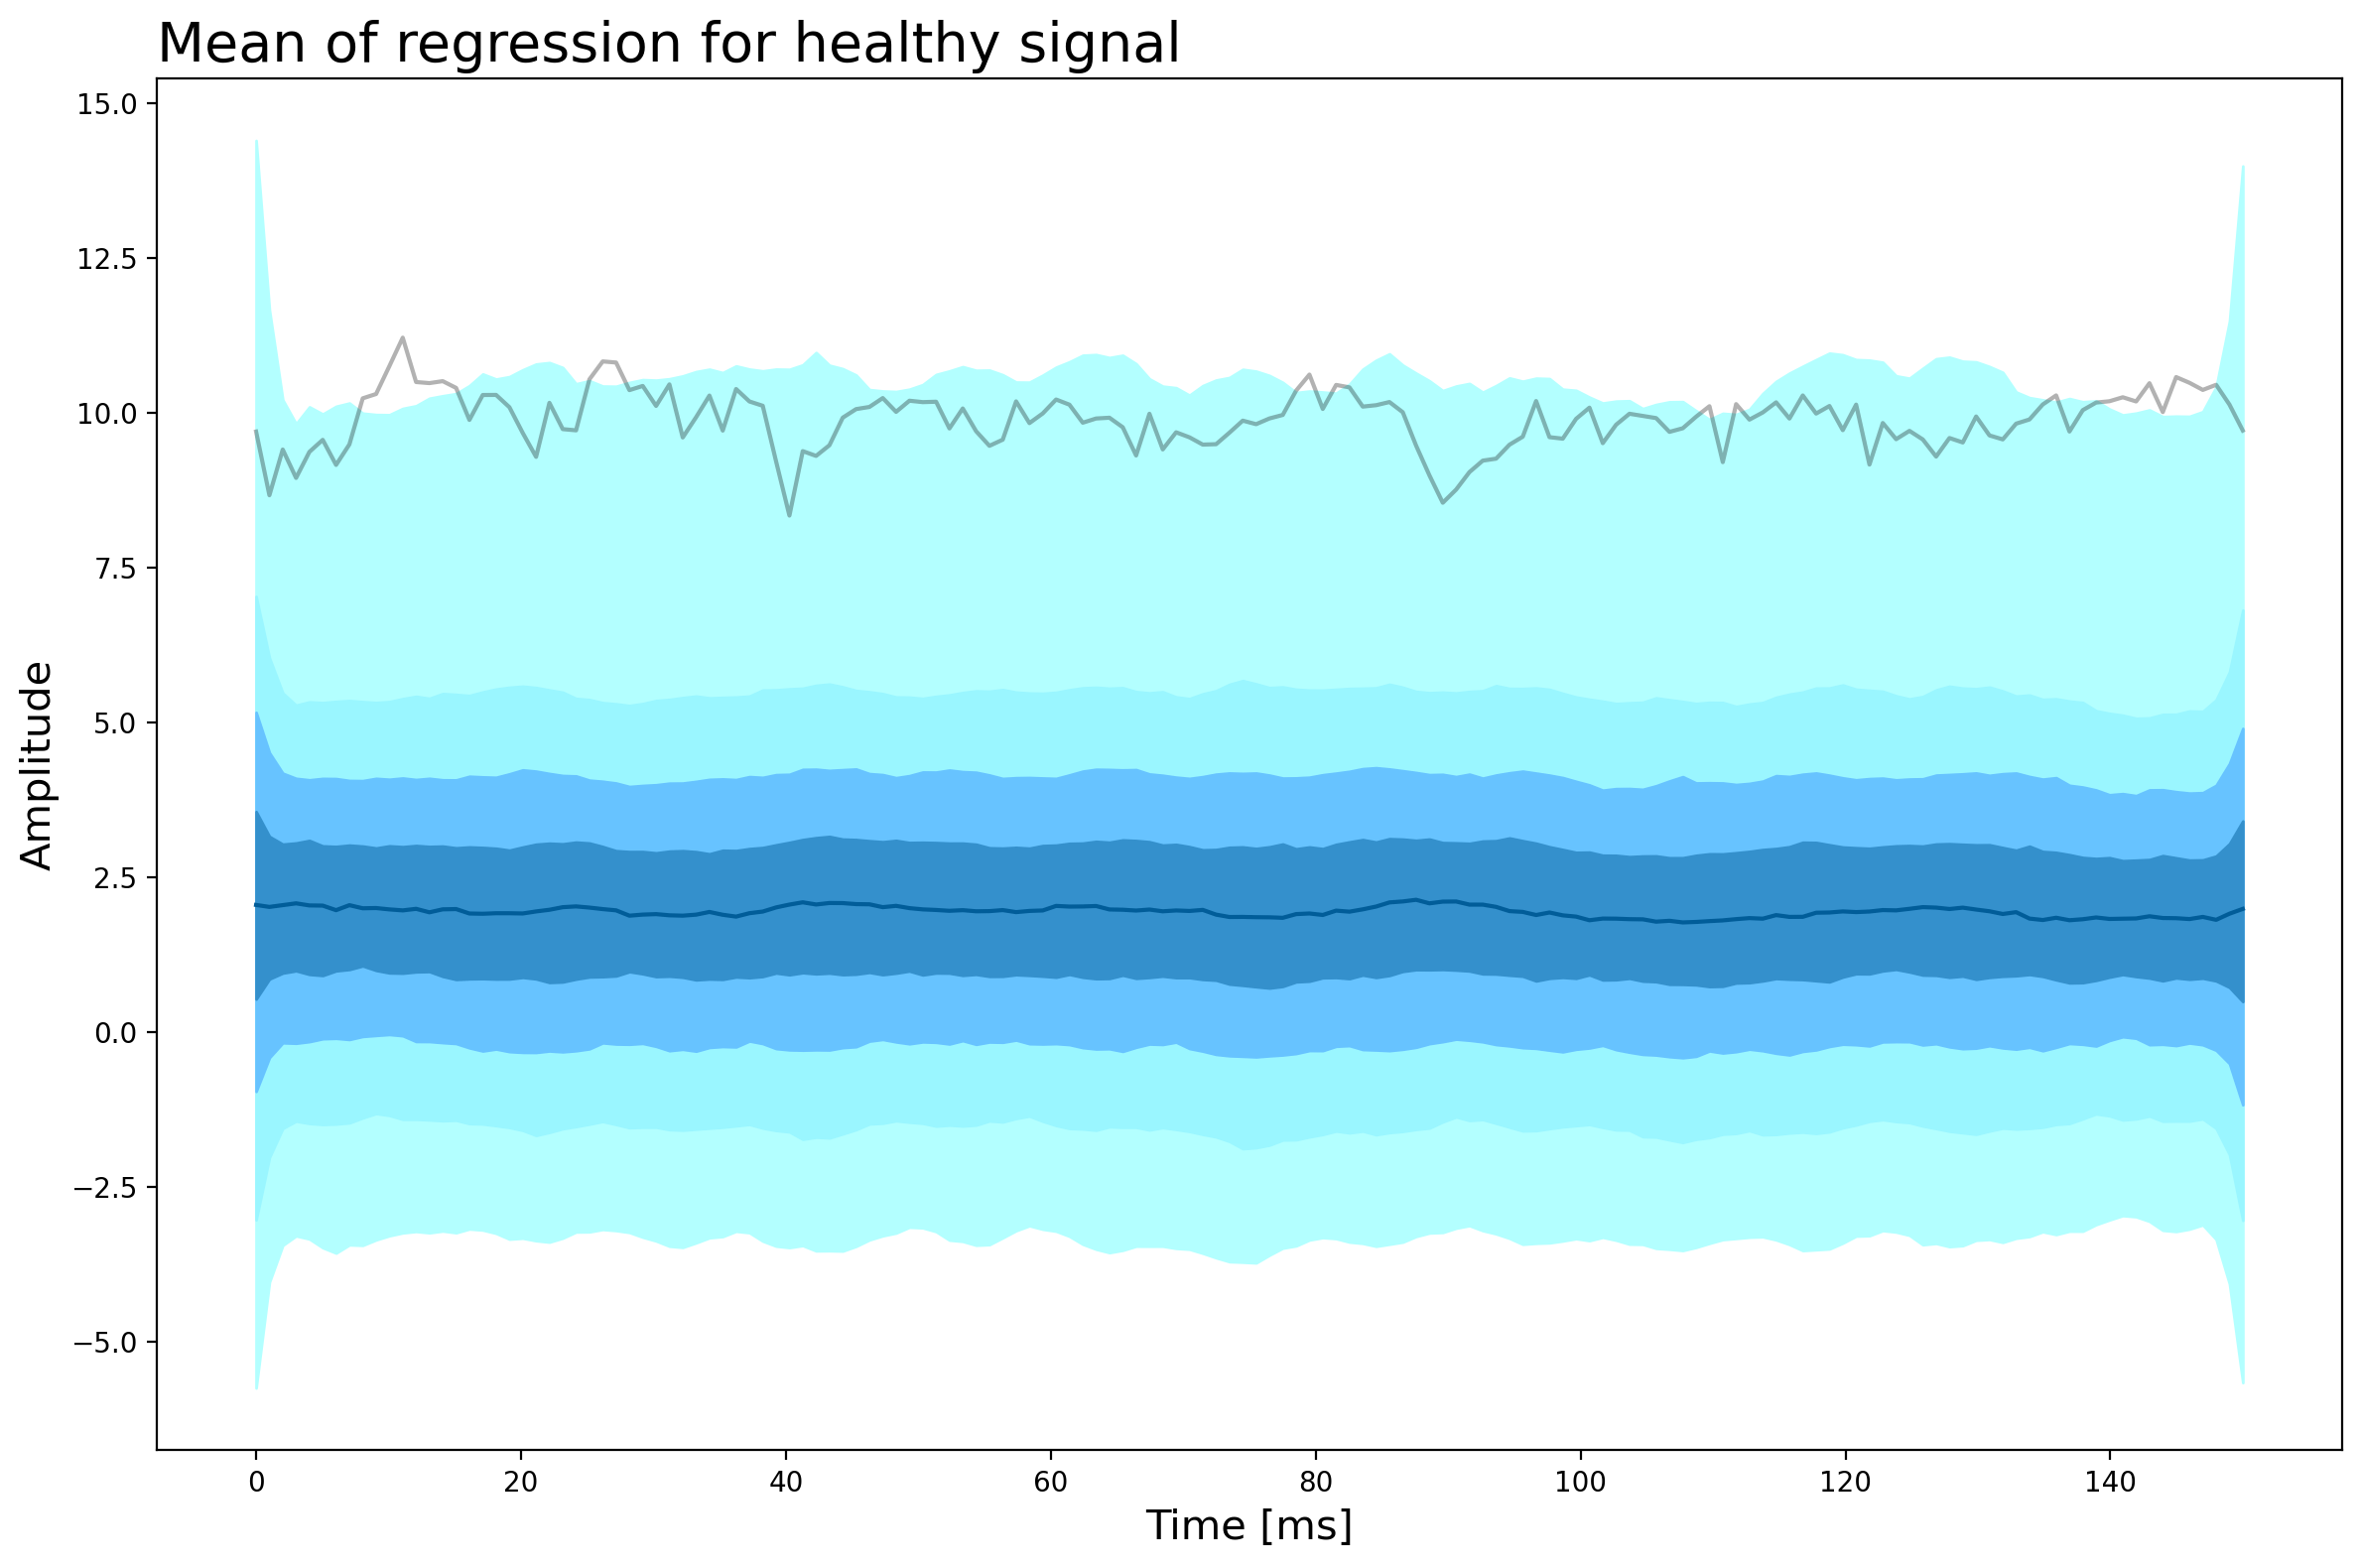

In [9]:
fig = plt.figure(figsize=(12, 8), tight_layout = True)
axes = plt.subplot(1, 1 ,1)
beta_pred= ppc_samples.stan_variable('betas')[:,:]
pred = beta_pred@B0.T
axes = ribbon_plot(x,pred,axes,supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 98])
axes.set_xlabel('Time [ms]',fontsize = 15)
axes.set_ylabel('Amplitude',fontsize = 15)
axes.set_title('Mean of regression for healthy signal', loc= 'left',fontsize = 20)
axes.plot(x,acc_healthy_data[1], color = 'k',alpha=0.3)

In [10]:
def prepare_data(data_array,spl_order = 3, num_knots = 30, frequencies = None, mode = 'binary', training_samples = 5,lambda0=None):
    N = len(data_array[0][0])
    spl_order = spl_order
    num_knots = num_knots
    if frequencies is None:
        times = np.linspace(0,N*10,N)
        knot_list = np.quantile(times,np.linspace(0,1,num_knots))
        B0 = create_spline_matrix(N, times, spl_order, num_knots)

    else:
        knot_list = np.quantile(frequencies,np.linspace(0,1,num_knots))
        B0 = create_spline_matrix(N, frequencies, spl_order, num_knots)

    K = num_knots+2
    if mode == 'binary':
        M = 2
        IL1 = training_samples
        IL2 = training_samples
        IL = IL1+IL2

        num_healthy = len(data_array[0])
        num_damaged = len(data_array[1])+len(data_array[2])
        data_array_damaged = np.concatenate([data_array[1],data_array[2]])
        total = num_healthy + num_damaged
        IT = total - IL

        sampling_order_1 = np.random.permutation([*range(num_healthy)])
        sampling_order_2 = np.random.permutation([*range(num_damaged)])

        y_labeled = np.concatenate(
        [np.array(data_array[0])[sampling_order_1[:IL1]],
            np.array(data_array_damaged)[sampling_order_2[:IL2]]])
        y_labeled = y_labeled.T
        labels = np.concatenate([np.ones(IL1), 2*np.ones(IL2)]).astype(int)


        y_test = np.concatenate(
            [np.array(data_array[0])[sampling_order_1[IL1:]],
                np.array(data_array_damaged)[sampling_order_2[IL2:]]
                ]
        )
        y_test = y_test.T
        y_test_labels = np.concatenate([np.ones(num_healthy-IL1), 2*np.ones(num_damaged-IL2)]).astype(int)
        if lambda0 is None:
            lambda0 = np.array([(IL1)/(IL), (IL2)/(IL)])

        IT = y_test.shape[1]

    if mode == 'all':
        M = 3
        IL1 = training_samples
        IL2 = training_samples
        IL3 = training_samples
        IL = IL1+IL2+IL3

        num_healthy = len(data_array[0])
        num_damaged = len(data_array[1])
        num_very_damaged = len(data_array[2])

        total = num_healthy + num_damaged + num_very_damaged
        IT = total - IL

        sampling_order_1 = np.random.permutation([*range(num_healthy)])
        sampling_order_2 = np.random.permutation([*range(num_damaged)])
        sampling_order_3 = np.random.permutation([*range(num_very_damaged)])

        y_labeled = np.concatenate(
        [np.array(data_array[0])[sampling_order_1[:IL1]],
            np.array(data_array[1])[sampling_order_2[:IL2]],
            np.array(data_array[2])[sampling_order_3[:IL3]],
            ])
        y_labeled = y_labeled.T
        labels = np.concatenate([np.ones(IL1), 2*np.ones(IL2), 3*np.ones(IL3)]).astype(int)


        y_test = np.concatenate(
            [np.array(data_array[0])[sampling_order_1[IL1:]],
                np.array(data_array[1])[sampling_order_2[IL2:]],
                np.array(data_array[2])[sampling_order_3[IL3:]]
                ]
        )
        y_test = y_test.T
        y_test_labels = np.concatenate([np.ones(num_healthy-IL1), 2*np.ones(num_damaged-IL2),3*np.ones(num_very_damaged-IL3)]).astype(int)
        if lambda0 is None:
            lambda0 = np.array([(IL1)/(IL), (IL2)/(IL), (IL3)/(IL)])

        IT = y_test.shape[1]

    data_out = {
    "N": N,
    "IL": IL,
    "K": K,
    "M": M,
    "x": B0,
    "labels": labels,
    "y_labeled": y_labeled,
    "lambda0": lambda0,
    "IT": IT,
    "y_test": y_test,
    }

    return data_out,y_test_labels,IT,IL, total, B0, knot_list
    

def get_results(model, data, labels, IT, IL, total, mode = 'binary', seed = None):
    if not seed:
        seed = np.random.randint(0,100000)
    if mode == 'binary':
        result = model.sample(data=data, seed=seed)
        probs_from_arviz = az.summary(
        result, "log_probabilities", kind='stats', round_to=5)
        probs_from_arviz_p = az.summary(
            result, "probabilities", kind='stats', round_to=5)
            
        indices_cat1 = labels == 1
        indices_cat2 = labels == 2

        cat1 = probs_from_arviz.iloc[:IT, :].iloc[indices_cat1, :]
        cat2 = probs_from_arviz.iloc[IT:2*IT, :].iloc[indices_cat2, :]

        cat1p = probs_from_arviz_p.iloc[:IT, :].iloc[indices_cat1, :]
        cat2p = probs_from_arviz_p.iloc[IT:2*IT, :].iloc[indices_cat2, :]


        a = sum((cat1["mean"].values) < np.log(0.5))
        b = sum((cat2["mean"].values) < np.log(0.5))

        hit_rate = 1 - (a+b)/(total-IL)
        print('hit rate = ',hit_rate)
    if mode == 'all':
        result = model.sample(data=data, seed=seed)
        probs_from_arviz = az.summary(
        result, "log_probabilities", kind='stats', round_to=5)
        probs_from_arviz_p = az.summary(
            result, "probabilities", kind='stats', round_to=5)
            
        indices_cat1 = labels == 1
        indices_cat2 = labels == 2
        indices_cat3 = labels == 2

        cat1 = probs_from_arviz.iloc[:IT, :].iloc[indices_cat1, :]
        cat2 = probs_from_arviz.iloc[IT:2*IT, :].iloc[indices_cat2, :]
        cat3 = probs_from_arviz.iloc[2*IT:3*IT, :].iloc[indices_cat3, :]

        cat1p = probs_from_arviz_p.iloc[:IT, :].iloc[indices_cat1, :]
        cat2p = probs_from_arviz_p.iloc[IT:2*IT, :].iloc[indices_cat2, :]
        cat3p = probs_from_arviz_p.iloc[2*IT:3*IT, :].iloc[indices_cat3, :]


        a = sum((cat1["mean"].values) < np.log(0.5))
        b = sum((cat2["mean"].values) < np.log(0.5))
        c = sum((cat3["mean"].values) < np.log(0.5))

        hit_rate = 1 - (a+b+c)/(total-IL)
        print('hit rate = ',hit_rate)
    return hit_rate
        




In [11]:
frequencies = gyro_damaged['Frequencies']
num_knots = 25
data, labels, IT, IL, total,B0,knot_list = prepare_data(acc,frequencies=None,training_samples=5, num_knots=num_knots, mode = 'binary')
model = CmdStanModel(stan_file='stan/mix.stan')
seed = 26042024
get_results(model=model,data=data,seed=seed,labels=labels,IT=IT,IL=IL,total=total,mode='binary')

01:42:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

01:42:14 - cmdstanpy - INFO - CmdStan done processing.



hit rate =  0.9642857142857143


0.9642857142857143

In [23]:
knots = [5,10,15,20,25]
result_dict_acc = {}
for num_knots in knots:
    res = []
    for i in range(100):
        data, labels, IT, IL, total,B0,knot_list = prepare_data(acc,frequencies=None,training_samples=5, num_knots=num_knots, mode = 'binary')
        res.append(get_results(model=model,data=data,labels=labels,IT=IT,IL=IL,total=total,mode='binary'))
    result_dict_acc[f'Spline {num_knots}'] = np.mean(res)
    pd_res = pd.DataFrame(result_dict_acc,index=[0])
    pd_res.to_csv('results/agg_results.csv')

model = CmdStanModel(stan_file='stan/mix.stan')

result_dict_gyro = {}
for num_knots in knots:
    res = []
    for i in range(100):
        data, labels, IT, IL, total,B0,knot_list = prepare_data(gyro,frequencies=frequencies,training_samples=5, num_knots=num_knots, mode = 'binary')
        res.append(get_results(model=model,data=data,labels=labels,IT=IT,IL=IL,total=total,mode='binary'))
    result_dict_gyro[f'Spline {num_knots}'] = np.mean(res)
    pd_res = pd.DataFrame(result_dict_gyro,index=[0])
    pd_res.to_csv('results/gyro_results.csv')

result_dict_gyro_agg = {}
for num_knots in knots:
    res = []
    for i in range(100):
        data, labels, IT, IL, total,B0,knot_list = prepare_data(gyro_agg,frequencies=frequencies,training_samples=5, num_knots=num_knots, mode = 'binary')
        res.append(get_results(model=model,data=data,labels=labels,IT=IT,IL=IL,total=total,mode='binary'))
    result_dict_gyro_agg[f'Spline {num_knots}'] = np.mean(res)
    pd_res = pd.DataFrame(result_dict_gyro_agg,index=[0])
    pd_res.to_csv('results/gyro_agg_results.csv')

02:20:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:20:41 - cmdstanpy - INFO - CmdStan done processing.


02:20:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:20:43 - cmdstanpy - INFO - CmdStan done processing.


02:20:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:20:46 - cmdstanpy - INFO - CmdStan done processing.


02:20:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:20:49 - cmdstanpy - INFO - CmdStan done processing.


02:20:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:20:52 - cmdstanpy - INFO - CmdStan done processing.
02:20:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:20:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:20:55 - cmdstanpy - INFO - CmdStan done processing.


02:20:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:20:58 - cmdstanpy - INFO - CmdStan done processing.


02:20:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:21:01 - cmdstanpy - INFO - CmdStan done processing.


02:21:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:21:04 - cmdstanpy - INFO - CmdStan done processing.
02:21:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:21:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:21:07 - cmdstanpy - INFO - CmdStan done processing.


02:21:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:21:10 - cmdstanpy - INFO - CmdStan done processing.


02:21:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:21:13 - cmdstanpy - INFO - CmdStan done processing.


02:21:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9821428571428571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:21:16 - cmdstanpy - INFO - CmdStan done processing.


02:21:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9821428571428571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:21:19 - cmdstanpy - INFO - CmdStan done processing.
02:21:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:21:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:21:22 - cmdstanpy - INFO - CmdStan done processing.
02:21:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:21:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:21:26 - cmdstanpy - INFO - CmdStan done processing.


02:21:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  1.0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:21:29 - cmdstanpy - INFO - CmdStan done processing.


02:21:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:21:33 - cmdstanpy - INFO - CmdStan done processing.


02:21:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:21:36 - cmdstanpy - INFO - CmdStan done processing.


02:21:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:21:39 - cmdstanpy - INFO - CmdStan done processing.


02:21:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:21:43 - cmdstanpy - INFO - CmdStan done processing.


02:21:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:21:46 - cmdstanpy - INFO - CmdStan done processing.


02:21:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:21:50 - cmdstanpy - INFO - CmdStan done processing.


02:21:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:21:53 - cmdstanpy - INFO - CmdStan done processing.


02:21:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:21:56 - cmdstanpy - INFO - CmdStan done processing.
02:21:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:21:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:22:00 - cmdstanpy - INFO - CmdStan done processing.


02:22:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:22:03 - cmdstanpy - INFO - CmdStan done processing.


02:22:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:22:07 - cmdstanpy - INFO - CmdStan done processing.


02:22:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:22:10 - cmdstanpy - INFO - CmdStan done processing.


02:22:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:22:13 - cmdstanpy - INFO - CmdStan done processing.


02:22:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:22:17 - cmdstanpy - INFO - CmdStan done processing.


02:22:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:22:20 - cmdstanpy - INFO - CmdStan done processing.


02:22:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:22:24 - cmdstanpy - INFO - CmdStan done processing.


02:22:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:22:27 - cmdstanpy - INFO - CmdStan done processing.


02:22:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:22:30 - cmdstanpy - INFO - CmdStan done processing.
02:22:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:22:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:22:34 - cmdstanpy - INFO - CmdStan done processing.


02:22:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:22:37 - cmdstanpy - INFO - CmdStan done processing.


02:22:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:22:40 - cmdstanpy - INFO - CmdStan done processing.
02:22:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:22:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:22:44 - cmdstanpy - INFO - CmdStan done processing.


02:22:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:22:47 - cmdstanpy - INFO - CmdStan done processing.


02:22:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:22:50 - cmdstanpy - INFO - CmdStan done processing.


02:22:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:22:54 - cmdstanpy - INFO - CmdStan done processing.


02:22:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9821428571428571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:22:57 - cmdstanpy - INFO - CmdStan done processing.


02:22:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:23:00 - cmdstanpy - INFO - CmdStan done processing.


02:23:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:23:04 - cmdstanpy - INFO - CmdStan done processing.
02:23:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:23:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:23:07 - cmdstanpy - INFO - CmdStan done processing.


02:23:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:23:10 - cmdstanpy - INFO - CmdStan done processing.
02:23:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:23:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:23:14 - cmdstanpy - INFO - CmdStan done processing.
02:23:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:23:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9821428571428571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:23:17 - cmdstanpy - INFO - CmdStan done processing.


02:23:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:23:21 - cmdstanpy - INFO - CmdStan done processing.


02:23:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:23:24 - cmdstanpy - INFO - CmdStan done processing.


02:23:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:23:27 - cmdstanpy - INFO - CmdStan done processing.


02:23:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:23:31 - cmdstanpy - INFO - CmdStan done processing.


02:23:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:23:34 - cmdstanpy - INFO - CmdStan done processing.


02:23:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:23:37 - cmdstanpy - INFO - CmdStan done processing.


02:23:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:23:41 - cmdstanpy - INFO - CmdStan done processing.


02:23:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:23:44 - cmdstanpy - INFO - CmdStan done processing.


02:23:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:23:47 - cmdstanpy - INFO - CmdStan done processing.


02:23:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:23:50 - cmdstanpy - INFO - CmdStan done processing.
02:23:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:23:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:23:54 - cmdstanpy - INFO - CmdStan done processing.


02:23:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:23:57 - cmdstanpy - INFO - CmdStan done processing.


02:23:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:24:01 - cmdstanpy - INFO - CmdStan done processing.


02:24:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:24:04 - cmdstanpy - INFO - CmdStan done processing.


02:24:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:24:07 - cmdstanpy - INFO - CmdStan done processing.


02:24:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:24:11 - cmdstanpy - INFO - CmdStan done processing.


02:24:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:24:14 - cmdstanpy - INFO - CmdStan done processing.


02:24:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:24:17 - cmdstanpy - INFO - CmdStan done processing.


02:24:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:24:21 - cmdstanpy - INFO - CmdStan done processing.
02:24:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:24:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:24:24 - cmdstanpy - INFO - CmdStan done processing.


02:24:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:24:27 - cmdstanpy - INFO - CmdStan done processing.


02:24:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  1.0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:24:31 - cmdstanpy - INFO - CmdStan done processing.


02:24:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:24:34 - cmdstanpy - INFO - CmdStan done processing.


02:24:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:24:38 - cmdstanpy - INFO - CmdStan done processing.


02:24:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:24:41 - cmdstanpy - INFO - CmdStan done processing.


02:24:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  1.0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:24:44 - cmdstanpy - INFO - CmdStan done processing.
02:24:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:24:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:24:47 - cmdstanpy - INFO - CmdStan done processing.


02:24:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:24:51 - cmdstanpy - INFO - CmdStan done processing.


02:24:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:24:54 - cmdstanpy - INFO - CmdStan done processing.


02:24:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:24:58 - cmdstanpy - INFO - CmdStan done processing.


02:24:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9821428571428571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:25:01 - cmdstanpy - INFO - CmdStan done processing.


02:25:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:25:04 - cmdstanpy - INFO - CmdStan done processing.


02:25:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:25:08 - cmdstanpy - INFO - CmdStan done processing.


02:25:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:25:11 - cmdstanpy - INFO - CmdStan done processing.


02:25:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:25:14 - cmdstanpy - INFO - CmdStan done processing.


02:25:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:25:18 - cmdstanpy - INFO - CmdStan done processing.


02:25:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:25:21 - cmdstanpy - INFO - CmdStan done processing.


02:25:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:25:24 - cmdstanpy - INFO - CmdStan done processing.


02:25:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:25:28 - cmdstanpy - INFO - CmdStan done processing.


02:25:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:25:31 - cmdstanpy - INFO - CmdStan done processing.


02:25:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:25:34 - cmdstanpy - INFO - CmdStan done processing.
02:25:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:25:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:25:38 - cmdstanpy - INFO - CmdStan done processing.


02:25:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:25:41 - cmdstanpy - INFO - CmdStan done processing.


02:25:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9821428571428571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:25:44 - cmdstanpy - INFO - CmdStan done processing.


02:25:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:25:48 - cmdstanpy - INFO - CmdStan done processing.


02:25:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:25:51 - cmdstanpy - INFO - CmdStan done processing.


02:25:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:25:55 - cmdstanpy - INFO - CmdStan done processing.


02:25:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:25:58 - cmdstanpy - INFO - CmdStan done processing.


02:25:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:26:01 - cmdstanpy - INFO - CmdStan done processing.
02:26:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:26:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:26:05 - cmdstanpy - INFO - CmdStan done processing.


02:26:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:26:08 - cmdstanpy - INFO - CmdStan done processing.


02:26:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:26:12 - cmdstanpy - INFO - CmdStan done processing.


02:26:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:26:15 - cmdstanpy - INFO - CmdStan done processing.


02:26:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:26:19 - cmdstanpy - INFO - CmdStan done processing.


02:26:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:26:22 - cmdstanpy - INFO - CmdStan done processing.
02:26:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:26:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:26:26 - cmdstanpy - INFO - CmdStan done processing.


02:26:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:26:30 - cmdstanpy - INFO - CmdStan done processing.


02:26:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:26:33 - cmdstanpy - INFO - CmdStan done processing.


02:26:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:26:37 - cmdstanpy - INFO - CmdStan done processing.


02:26:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:26:40 - cmdstanpy - INFO - CmdStan done processing.


02:26:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:26:44 - cmdstanpy - INFO - CmdStan done processing.


02:26:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:26:47 - cmdstanpy - INFO - CmdStan done processing.


02:26:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:26:51 - cmdstanpy - INFO - CmdStan done processing.


02:26:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:26:55 - cmdstanpy - INFO - CmdStan done processing.
02:26:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:26:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:26:58 - cmdstanpy - INFO - CmdStan done processing.


02:26:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:27:02 - cmdstanpy - INFO - CmdStan done processing.


02:27:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:27:05 - cmdstanpy - INFO - CmdStan done processing.


02:27:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:27:09 - cmdstanpy - INFO - CmdStan done processing.


02:27:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:27:13 - cmdstanpy - INFO - CmdStan done processing.
02:27:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:27:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:27:16 - cmdstanpy - INFO - CmdStan done processing.


02:27:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:27:20 - cmdstanpy - INFO - CmdStan done processing.


02:27:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:27:23 - cmdstanpy - INFO - CmdStan done processing.


02:27:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:27:27 - cmdstanpy - INFO - CmdStan done processing.


02:27:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:27:30 - cmdstanpy - INFO - CmdStan done processing.


02:27:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:27:34 - cmdstanpy - INFO - CmdStan done processing.


02:27:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:27:38 - cmdstanpy - INFO - CmdStan done processing.


02:27:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:27:41 - cmdstanpy - INFO - CmdStan done processing.


02:27:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:27:45 - cmdstanpy - INFO - CmdStan done processing.


02:27:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:27:49 - cmdstanpy - INFO - CmdStan done processing.


02:27:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:27:53 - cmdstanpy - INFO - CmdStan done processing.
02:27:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:27:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:27:56 - cmdstanpy - INFO - CmdStan done processing.


02:27:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:28:00 - cmdstanpy - INFO - CmdStan done processing.


02:28:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:28:04 - cmdstanpy - INFO - CmdStan done processing.


02:28:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:28:07 - cmdstanpy - INFO - CmdStan done processing.


02:28:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:28:11 - cmdstanpy - INFO - CmdStan done processing.


02:28:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:28:14 - cmdstanpy - INFO - CmdStan done processing.


02:28:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:28:18 - cmdstanpy - INFO - CmdStan done processing.


02:28:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:28:22 - cmdstanpy - INFO - CmdStan done processing.


02:28:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:28:25 - cmdstanpy - INFO - CmdStan done processing.


02:28:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:28:29 - cmdstanpy - INFO - CmdStan done processing.


02:28:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:28:32 - cmdstanpy - INFO - CmdStan done processing.


02:28:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:28:36 - cmdstanpy - INFO - CmdStan done processing.


02:28:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:28:40 - cmdstanpy - INFO - CmdStan done processing.


02:28:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:28:43 - cmdstanpy - INFO - CmdStan done processing.


02:28:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:28:47 - cmdstanpy - INFO - CmdStan done processing.


02:28:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:28:50 - cmdstanpy - INFO - CmdStan done processing.


02:28:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:28:54 - cmdstanpy - INFO - CmdStan done processing.


02:28:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:28:58 - cmdstanpy - INFO - CmdStan done processing.


02:28:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:29:01 - cmdstanpy - INFO - CmdStan done processing.


02:29:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:29:05 - cmdstanpy - INFO - CmdStan done processing.


02:29:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:29:08 - cmdstanpy - INFO - CmdStan done processing.


02:29:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:29:12 - cmdstanpy - INFO - CmdStan done processing.


02:29:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9821428571428571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:29:15 - cmdstanpy - INFO - CmdStan done processing.


02:29:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:29:19 - cmdstanpy - INFO - CmdStan done processing.


02:29:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:29:23 - cmdstanpy - INFO - CmdStan done processing.


02:29:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:29:26 - cmdstanpy - INFO - CmdStan done processing.


02:29:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:29:30 - cmdstanpy - INFO - CmdStan done processing.


02:29:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:29:33 - cmdstanpy - INFO - CmdStan done processing.


02:29:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:29:37 - cmdstanpy - INFO - CmdStan done processing.
02:29:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:29:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:29:41 - cmdstanpy - INFO - CmdStan done processing.


02:29:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:29:44 - cmdstanpy - INFO - CmdStan done processing.


02:29:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:29:48 - cmdstanpy - INFO - CmdStan done processing.


02:29:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:29:51 - cmdstanpy - INFO - CmdStan done processing.


02:29:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:29:55 - cmdstanpy - INFO - CmdStan done processing.


02:29:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  1.0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:29:59 - cmdstanpy - INFO - CmdStan done processing.


02:29:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:30:02 - cmdstanpy - INFO - CmdStan done processing.


02:30:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:30:06 - cmdstanpy - INFO - CmdStan done processing.


02:30:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:30:09 - cmdstanpy - INFO - CmdStan done processing.


02:30:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:30:13 - cmdstanpy - INFO - CmdStan done processing.


02:30:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:30:16 - cmdstanpy - INFO - CmdStan done processing.


02:30:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:30:20 - cmdstanpy - INFO - CmdStan done processing.


02:30:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:30:23 - cmdstanpy - INFO - CmdStan done processing.


02:30:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:30:27 - cmdstanpy - INFO - CmdStan done processing.


02:30:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:30:30 - cmdstanpy - INFO - CmdStan done processing.
02:30:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:30:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:30:34 - cmdstanpy - INFO - CmdStan done processing.


02:30:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:30:38 - cmdstanpy - INFO - CmdStan done processing.


02:30:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:30:41 - cmdstanpy - INFO - CmdStan done processing.
02:30:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:30:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:30:45 - cmdstanpy - INFO - CmdStan done processing.
02:30:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:30:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:30:48 - cmdstanpy - INFO - CmdStan done processing.


02:30:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:30:52 - cmdstanpy - INFO - CmdStan done processing.


02:30:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:30:56 - cmdstanpy - INFO - CmdStan done processing.
02:30:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:30:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:30:59 - cmdstanpy - INFO - CmdStan done processing.


02:31:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:31:03 - cmdstanpy - INFO - CmdStan done processing.


02:31:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:31:06 - cmdstanpy - INFO - CmdStan done processing.


02:31:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:31:10 - cmdstanpy - INFO - CmdStan done processing.
02:31:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:31:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:31:14 - cmdstanpy - INFO - CmdStan done processing.


02:31:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:31:17 - cmdstanpy - INFO - CmdStan done processing.


02:31:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:31:21 - cmdstanpy - INFO - CmdStan done processing.


02:31:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:31:24 - cmdstanpy - INFO - CmdStan done processing.
02:31:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:31:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:31:28 - cmdstanpy - INFO - CmdStan done processing.


02:31:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:31:32 - cmdstanpy - INFO - CmdStan done processing.


02:31:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:31:35 - cmdstanpy - INFO - CmdStan done processing.


02:31:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:31:39 - cmdstanpy - INFO - CmdStan done processing.


02:31:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:31:42 - cmdstanpy - INFO - CmdStan done processing.


02:31:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:31:46 - cmdstanpy - INFO - CmdStan done processing.
02:31:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:31:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:31:50 - cmdstanpy - INFO - CmdStan done processing.


02:31:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:31:53 - cmdstanpy - INFO - CmdStan done processing.
02:31:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:31:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:31:57 - cmdstanpy - INFO - CmdStan done processing.


02:31:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:32:01 - cmdstanpy - INFO - CmdStan done processing.


02:32:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:32:04 - cmdstanpy - INFO - CmdStan done processing.


02:32:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:32:08 - cmdstanpy - INFO - CmdStan done processing.


02:32:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:32:12 - cmdstanpy - INFO - CmdStan done processing.


02:32:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:32:16 - cmdstanpy - INFO - CmdStan done processing.


02:32:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:32:20 - cmdstanpy - INFO - CmdStan done processing.


02:32:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:32:24 - cmdstanpy - INFO - CmdStan done processing.


02:32:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:32:28 - cmdstanpy - INFO - CmdStan done processing.


02:32:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:32:31 - cmdstanpy - INFO - CmdStan done processing.


02:32:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:32:35 - cmdstanpy - INFO - CmdStan done processing.


02:32:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:32:39 - cmdstanpy - INFO - CmdStan done processing.


02:32:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:32:43 - cmdstanpy - INFO - CmdStan done processing.


02:32:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:32:47 - cmdstanpy - INFO - CmdStan done processing.
02:32:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:32:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:32:51 - cmdstanpy - INFO - CmdStan done processing.


02:32:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:32:55 - cmdstanpy - INFO - CmdStan done processing.


02:32:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:32:59 - cmdstanpy - INFO - CmdStan done processing.


02:32:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:33:02 - cmdstanpy - INFO - CmdStan done processing.


02:33:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:33:06 - cmdstanpy - INFO - CmdStan done processing.


02:33:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:33:10 - cmdstanpy - INFO - CmdStan done processing.


02:33:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:33:14 - cmdstanpy - INFO - CmdStan done processing.


02:33:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:33:18 - cmdstanpy - INFO - CmdStan done processing.


02:33:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:33:21 - cmdstanpy - INFO - CmdStan done processing.


02:33:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:33:25 - cmdstanpy - INFO - CmdStan done processing.


02:33:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:33:29 - cmdstanpy - INFO - CmdStan done processing.


02:33:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:33:33 - cmdstanpy - INFO - CmdStan done processing.


02:33:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:33:37 - cmdstanpy - INFO - CmdStan done processing.


02:33:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:33:41 - cmdstanpy - INFO - CmdStan done processing.


02:33:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:33:45 - cmdstanpy - INFO - CmdStan done processing.


02:33:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:33:48 - cmdstanpy - INFO - CmdStan done processing.


02:33:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:33:52 - cmdstanpy - INFO - CmdStan done processing.


02:33:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:33:56 - cmdstanpy - INFO - CmdStan done processing.


02:33:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:34:00 - cmdstanpy - INFO - CmdStan done processing.


02:34:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:34:04 - cmdstanpy - INFO - CmdStan done processing.


02:34:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:34:08 - cmdstanpy - INFO - CmdStan done processing.


02:34:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:34:12 - cmdstanpy - INFO - CmdStan done processing.


02:34:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:34:16 - cmdstanpy - INFO - CmdStan done processing.


02:34:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:34:19 - cmdstanpy - INFO - CmdStan done processing.


02:34:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:34:23 - cmdstanpy - INFO - CmdStan done processing.


02:34:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:34:27 - cmdstanpy - INFO - CmdStan done processing.


02:34:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:34:31 - cmdstanpy - INFO - CmdStan done processing.


02:34:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:34:35 - cmdstanpy - INFO - CmdStan done processing.


02:34:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:34:39 - cmdstanpy - INFO - CmdStan done processing.


02:34:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:34:43 - cmdstanpy - INFO - CmdStan done processing.


02:34:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:34:47 - cmdstanpy - INFO - CmdStan done processing.


02:34:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:34:51 - cmdstanpy - INFO - CmdStan done processing.


02:34:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:34:55 - cmdstanpy - INFO - CmdStan done processing.


02:34:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:34:59 - cmdstanpy - INFO - CmdStan done processing.


02:34:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:35:02 - cmdstanpy - INFO - CmdStan done processing.


02:35:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:35:06 - cmdstanpy - INFO - CmdStan done processing.


02:35:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:35:10 - cmdstanpy - INFO - CmdStan done processing.


02:35:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:35:14 - cmdstanpy - INFO - CmdStan done processing.


02:35:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:35:18 - cmdstanpy - INFO - CmdStan done processing.


02:35:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:35:22 - cmdstanpy - INFO - CmdStan done processing.


02:35:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:35:26 - cmdstanpy - INFO - CmdStan done processing.


02:35:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:35:30 - cmdstanpy - INFO - CmdStan done processing.


02:35:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:35:33 - cmdstanpy - INFO - CmdStan done processing.


02:35:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:35:37 - cmdstanpy - INFO - CmdStan done processing.


02:35:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:35:41 - cmdstanpy - INFO - CmdStan done processing.


02:35:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:35:45 - cmdstanpy - INFO - CmdStan done processing.


02:35:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:35:49 - cmdstanpy - INFO - CmdStan done processing.


02:35:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:35:53 - cmdstanpy - INFO - CmdStan done processing.


02:35:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:35:57 - cmdstanpy - INFO - CmdStan done processing.
02:35:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:35:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:36:01 - cmdstanpy - INFO - CmdStan done processing.


02:36:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:36:05 - cmdstanpy - INFO - CmdStan done processing.


02:36:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:36:08 - cmdstanpy - INFO - CmdStan done processing.


02:36:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:36:12 - cmdstanpy - INFO - CmdStan done processing.


02:36:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:36:16 - cmdstanpy - INFO - CmdStan done processing.


02:36:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:36:20 - cmdstanpy - INFO - CmdStan done processing.


02:36:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:36:24 - cmdstanpy - INFO - CmdStan done processing.


02:36:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:36:28 - cmdstanpy - INFO - CmdStan done processing.


02:36:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:36:32 - cmdstanpy - INFO - CmdStan done processing.


02:36:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:36:36 - cmdstanpy - INFO - CmdStan done processing.


02:36:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:36:39 - cmdstanpy - INFO - CmdStan done processing.


02:36:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9821428571428571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:36:43 - cmdstanpy - INFO - CmdStan done processing.


02:36:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:36:47 - cmdstanpy - INFO - CmdStan done processing.
02:36:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:36:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:36:51 - cmdstanpy - INFO - CmdStan done processing.


02:36:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:36:55 - cmdstanpy - INFO - CmdStan done processing.
02:36:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:36:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:36:59 - cmdstanpy - INFO - CmdStan done processing.


02:36:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:37:03 - cmdstanpy - INFO - CmdStan done processing.
02:37:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:37:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:37:06 - cmdstanpy - INFO - CmdStan done processing.


02:37:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:37:10 - cmdstanpy - INFO - CmdStan done processing.


02:37:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:37:14 - cmdstanpy - INFO - CmdStan done processing.


02:37:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:37:18 - cmdstanpy - INFO - CmdStan done processing.


02:37:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:37:22 - cmdstanpy - INFO - CmdStan done processing.
02:37:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:37:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:37:26 - cmdstanpy - INFO - CmdStan done processing.


02:37:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:37:29 - cmdstanpy - INFO - CmdStan done processing.


02:37:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:37:33 - cmdstanpy - INFO - CmdStan done processing.
02:37:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:37:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:37:37 - cmdstanpy - INFO - CmdStan done processing.


02:37:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:37:41 - cmdstanpy - INFO - CmdStan done processing.


02:37:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:37:45 - cmdstanpy - INFO - CmdStan done processing.


02:37:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:37:49 - cmdstanpy - INFO - CmdStan done processing.


02:37:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:37:53 - cmdstanpy - INFO - CmdStan done processing.


02:37:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:37:57 - cmdstanpy - INFO - CmdStan done processing.


02:37:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:38:01 - cmdstanpy - INFO - CmdStan done processing.
02:38:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:38:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:38:05 - cmdstanpy - INFO - CmdStan done processing.
02:38:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:38:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:38:09 - cmdstanpy - INFO - CmdStan done processing.


02:38:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:38:12 - cmdstanpy - INFO - CmdStan done processing.


02:38:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:38:16 - cmdstanpy - INFO - CmdStan done processing.


02:38:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:38:20 - cmdstanpy - INFO - CmdStan done processing.


02:38:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:38:24 - cmdstanpy - INFO - CmdStan done processing.


02:38:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:38:28 - cmdstanpy - INFO - CmdStan done processing.


02:38:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:38:32 - cmdstanpy - INFO - CmdStan done processing.
02:38:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:38:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:38:36 - cmdstanpy - INFO - CmdStan done processing.


02:38:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:38:40 - cmdstanpy - INFO - CmdStan done processing.


02:38:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:38:44 - cmdstanpy - INFO - CmdStan done processing.


02:38:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:38:48 - cmdstanpy - INFO - CmdStan done processing.


02:38:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:38:53 - cmdstanpy - INFO - CmdStan done processing.
02:38:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:38:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:38:57 - cmdstanpy - INFO - CmdStan done processing.


02:38:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:39:01 - cmdstanpy - INFO - CmdStan done processing.
02:39:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:39:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:39:05 - cmdstanpy - INFO - CmdStan done processing.


02:39:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:39:10 - cmdstanpy - INFO - CmdStan done processing.


02:39:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:39:14 - cmdstanpy - INFO - CmdStan done processing.


02:39:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:39:18 - cmdstanpy - INFO - CmdStan done processing.


02:39:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:39:22 - cmdstanpy - INFO - CmdStan done processing.


02:39:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:39:27 - cmdstanpy - INFO - CmdStan done processing.


02:39:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:39:31 - cmdstanpy - INFO - CmdStan done processing.


02:39:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:39:35 - cmdstanpy - INFO - CmdStan done processing.


02:39:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:39:39 - cmdstanpy - INFO - CmdStan done processing.


02:39:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:39:44 - cmdstanpy - INFO - CmdStan done processing.


02:39:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:39:48 - cmdstanpy - INFO - CmdStan done processing.


02:39:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:39:52 - cmdstanpy - INFO - CmdStan done processing.


02:39:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:39:56 - cmdstanpy - INFO - CmdStan done processing.


02:39:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:40:00 - cmdstanpy - INFO - CmdStan done processing.


02:40:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:40:04 - cmdstanpy - INFO - CmdStan done processing.


02:40:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:40:09 - cmdstanpy - INFO - CmdStan done processing.


02:40:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:40:13 - cmdstanpy - INFO - CmdStan done processing.


02:40:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:40:17 - cmdstanpy - INFO - CmdStan done processing.


02:40:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:40:21 - cmdstanpy - INFO - CmdStan done processing.


02:40:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:40:25 - cmdstanpy - INFO - CmdStan done processing.


02:40:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:40:29 - cmdstanpy - INFO - CmdStan done processing.


02:40:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:40:33 - cmdstanpy - INFO - CmdStan done processing.


02:40:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:40:38 - cmdstanpy - INFO - CmdStan done processing.


02:40:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:40:42 - cmdstanpy - INFO - CmdStan done processing.


02:40:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:40:46 - cmdstanpy - INFO - CmdStan done processing.
02:40:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:40:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:40:50 - cmdstanpy - INFO - CmdStan done processing.


02:40:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:40:54 - cmdstanpy - INFO - CmdStan done processing.


02:40:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:40:59 - cmdstanpy - INFO - CmdStan done processing.


02:40:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:41:03 - cmdstanpy - INFO - CmdStan done processing.
02:41:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:41:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:41:07 - cmdstanpy - INFO - CmdStan done processing.


02:41:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:41:11 - cmdstanpy - INFO - CmdStan done processing.


02:41:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:41:16 - cmdstanpy - INFO - CmdStan done processing.
02:41:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:41:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:41:20 - cmdstanpy - INFO - CmdStan done processing.


02:41:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:41:24 - cmdstanpy - INFO - CmdStan done processing.


02:41:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:41:28 - cmdstanpy - INFO - CmdStan done processing.


02:41:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:41:33 - cmdstanpy - INFO - CmdStan done processing.


02:41:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:41:37 - cmdstanpy - INFO - CmdStan done processing.


02:41:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:41:41 - cmdstanpy - INFO - CmdStan done processing.


02:41:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:41:45 - cmdstanpy - INFO - CmdStan done processing.


02:41:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:41:49 - cmdstanpy - INFO - CmdStan done processing.


02:41:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:41:53 - cmdstanpy - INFO - CmdStan done processing.


02:41:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:41:58 - cmdstanpy - INFO - CmdStan done processing.


02:41:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:42:02 - cmdstanpy - INFO - CmdStan done processing.
02:42:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:42:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:42:06 - cmdstanpy - INFO - CmdStan done processing.
02:42:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:42:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:42:10 - cmdstanpy - INFO - CmdStan done processing.


02:42:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:42:14 - cmdstanpy - INFO - CmdStan done processing.


02:42:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:42:18 - cmdstanpy - INFO - CmdStan done processing.


02:42:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:42:23 - cmdstanpy - INFO - CmdStan done processing.
02:42:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:42:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:42:27 - cmdstanpy - INFO - CmdStan done processing.


02:42:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:42:31 - cmdstanpy - INFO - CmdStan done processing.


02:42:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:42:35 - cmdstanpy - INFO - CmdStan done processing.


02:42:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:42:40 - cmdstanpy - INFO - CmdStan done processing.


02:42:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:42:44 - cmdstanpy - INFO - CmdStan done processing.


02:42:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:42:48 - cmdstanpy - INFO - CmdStan done processing.


02:42:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:42:52 - cmdstanpy - INFO - CmdStan done processing.


02:42:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:42:56 - cmdstanpy - INFO - CmdStan done processing.


02:42:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:43:00 - cmdstanpy - INFO - CmdStan done processing.


02:43:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:43:04 - cmdstanpy - INFO - CmdStan done processing.


02:43:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:43:09 - cmdstanpy - INFO - CmdStan done processing.


02:43:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:43:13 - cmdstanpy - INFO - CmdStan done processing.
02:43:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:43:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:43:17 - cmdstanpy - INFO - CmdStan done processing.


02:43:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:43:21 - cmdstanpy - INFO - CmdStan done processing.


02:43:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:43:25 - cmdstanpy - INFO - CmdStan done processing.


02:43:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:43:30 - cmdstanpy - INFO - CmdStan done processing.


02:43:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:43:34 - cmdstanpy - INFO - CmdStan done processing.
02:43:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:43:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:43:38 - cmdstanpy - INFO - CmdStan done processing.


02:43:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:43:42 - cmdstanpy - INFO - CmdStan done processing.


02:43:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:43:47 - cmdstanpy - INFO - CmdStan done processing.


02:43:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:43:51 - cmdstanpy - INFO - CmdStan done processing.


02:43:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:43:55 - cmdstanpy - INFO - CmdStan done processing.
02:43:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:43:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:43:59 - cmdstanpy - INFO - CmdStan done processing.
02:43:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:44:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:44:03 - cmdstanpy - INFO - CmdStan done processing.


02:44:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:44:08 - cmdstanpy - INFO - CmdStan done processing.


02:44:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:44:12 - cmdstanpy - INFO - CmdStan done processing.


02:44:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:44:16 - cmdstanpy - INFO - CmdStan done processing.


02:44:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:44:20 - cmdstanpy - INFO - CmdStan done processing.
02:44:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:44:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:44:24 - cmdstanpy - INFO - CmdStan done processing.


02:44:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:44:28 - cmdstanpy - INFO - CmdStan done processing.


02:44:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:44:33 - cmdstanpy - INFO - CmdStan done processing.


02:44:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:44:37 - cmdstanpy - INFO - CmdStan done processing.


02:44:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:44:41 - cmdstanpy - INFO - CmdStan done processing.


02:44:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:44:45 - cmdstanpy - INFO - CmdStan done processing.


02:44:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:44:49 - cmdstanpy - INFO - CmdStan done processing.


02:44:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:44:53 - cmdstanpy - INFO - CmdStan done processing.


02:44:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:44:58 - cmdstanpy - INFO - CmdStan done processing.


02:44:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:45:02 - cmdstanpy - INFO - CmdStan done processing.


02:45:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:45:06 - cmdstanpy - INFO - CmdStan done processing.


02:45:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:45:10 - cmdstanpy - INFO - CmdStan done processing.


02:45:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:45:14 - cmdstanpy - INFO - CmdStan done processing.


02:45:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:45:18 - cmdstanpy - INFO - CmdStan done processing.


02:45:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:45:23 - cmdstanpy - INFO - CmdStan done processing.
02:45:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:45:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:45:27 - cmdstanpy - INFO - CmdStan done processing.


02:45:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:45:31 - cmdstanpy - INFO - CmdStan done processing.


02:45:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:45:35 - cmdstanpy - INFO - CmdStan done processing.


02:45:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:45:40 - cmdstanpy - INFO - CmdStan done processing.


02:45:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:45:44 - cmdstanpy - INFO - CmdStan done processing.


02:45:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:45:49 - cmdstanpy - INFO - CmdStan done processing.


02:45:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:45:53 - cmdstanpy - INFO - CmdStan done processing.


02:45:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:45:58 - cmdstanpy - INFO - CmdStan done processing.


02:45:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:46:02 - cmdstanpy - INFO - CmdStan done processing.
02:46:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:46:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:46:07 - cmdstanpy - INFO - CmdStan done processing.


02:46:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:46:11 - cmdstanpy - INFO - CmdStan done processing.


02:46:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:46:16 - cmdstanpy - INFO - CmdStan done processing.


02:46:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:46:20 - cmdstanpy - INFO - CmdStan done processing.


02:46:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:46:25 - cmdstanpy - INFO - CmdStan done processing.


02:46:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:46:29 - cmdstanpy - INFO - CmdStan done processing.


02:46:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:46:34 - cmdstanpy - INFO - CmdStan done processing.


02:46:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:46:39 - cmdstanpy - INFO - CmdStan done processing.


02:46:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:46:43 - cmdstanpy - INFO - CmdStan done processing.


02:46:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:46:48 - cmdstanpy - INFO - CmdStan done processing.
02:46:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:46:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:46:52 - cmdstanpy - INFO - CmdStan done processing.
02:46:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:46:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:46:57 - cmdstanpy - INFO - CmdStan done processing.


02:46:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:47:01 - cmdstanpy - INFO - CmdStan done processing.


02:47:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:47:06 - cmdstanpy - INFO - CmdStan done processing.


02:47:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:47:10 - cmdstanpy - INFO - CmdStan done processing.


02:47:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:47:15 - cmdstanpy - INFO - CmdStan done processing.


02:47:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:47:20 - cmdstanpy - INFO - CmdStan done processing.


02:47:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:47:24 - cmdstanpy - INFO - CmdStan done processing.


02:47:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:47:29 - cmdstanpy - INFO - CmdStan done processing.


02:47:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:47:33 - cmdstanpy - INFO - CmdStan done processing.


02:47:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:47:38 - cmdstanpy - INFO - CmdStan done processing.


02:47:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:47:42 - cmdstanpy - INFO - CmdStan done processing.


02:47:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:47:47 - cmdstanpy - INFO - CmdStan done processing.


02:47:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:47:51 - cmdstanpy - INFO - CmdStan done processing.


02:47:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:47:56 - cmdstanpy - INFO - CmdStan done processing.


02:47:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:48:00 - cmdstanpy - INFO - CmdStan done processing.


02:48:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:48:05 - cmdstanpy - INFO - CmdStan done processing.


02:48:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:48:09 - cmdstanpy - INFO - CmdStan done processing.


02:48:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:48:14 - cmdstanpy - INFO - CmdStan done processing.
02:48:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:48:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:48:19 - cmdstanpy - INFO - CmdStan done processing.


02:48:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:48:23 - cmdstanpy - INFO - CmdStan done processing.


02:48:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:48:28 - cmdstanpy - INFO - CmdStan done processing.


02:48:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:48:32 - cmdstanpy - INFO - CmdStan done processing.


02:48:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:48:37 - cmdstanpy - INFO - CmdStan done processing.
02:48:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:48:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:48:41 - cmdstanpy - INFO - CmdStan done processing.


02:48:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:48:46 - cmdstanpy - INFO - CmdStan done processing.
02:48:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:48:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:48:50 - cmdstanpy - INFO - CmdStan done processing.


02:48:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:48:55 - cmdstanpy - INFO - CmdStan done processing.
02:48:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:48:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:48:59 - cmdstanpy - INFO - CmdStan done processing.


02:49:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:49:04 - cmdstanpy - INFO - CmdStan done processing.
02:49:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:49:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:49:09 - cmdstanpy - INFO - CmdStan done processing.


02:49:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:49:13 - cmdstanpy - INFO - CmdStan done processing.


02:49:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:49:18 - cmdstanpy - INFO - CmdStan done processing.


02:49:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:49:22 - cmdstanpy - INFO - CmdStan done processing.


02:49:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:49:27 - cmdstanpy - INFO - CmdStan done processing.


02:49:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:49:31 - cmdstanpy - INFO - CmdStan done processing.


02:49:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:49:36 - cmdstanpy - INFO - CmdStan done processing.


02:49:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:49:41 - cmdstanpy - INFO - CmdStan done processing.


02:49:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:49:45 - cmdstanpy - INFO - CmdStan done processing.


02:49:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:49:50 - cmdstanpy - INFO - CmdStan done processing.


02:49:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:49:54 - cmdstanpy - INFO - CmdStan done processing.


02:49:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:49:59 - cmdstanpy - INFO - CmdStan done processing.


02:49:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:50:03 - cmdstanpy - INFO - CmdStan done processing.


02:50:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:50:08 - cmdstanpy - INFO - CmdStan done processing.
02:50:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:50:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:50:13 - cmdstanpy - INFO - CmdStan done processing.
02:50:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:50:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:50:17 - cmdstanpy - INFO - CmdStan done processing.


02:50:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:50:22 - cmdstanpy - INFO - CmdStan done processing.


02:50:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:50:26 - cmdstanpy - INFO - CmdStan done processing.


02:50:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:50:31 - cmdstanpy - INFO - CmdStan done processing.


02:50:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:50:35 - cmdstanpy - INFO - CmdStan done processing.


02:50:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:50:40 - cmdstanpy - INFO - CmdStan done processing.


02:50:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:50:44 - cmdstanpy - INFO - CmdStan done processing.


02:50:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:50:49 - cmdstanpy - INFO - CmdStan done processing.


02:50:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:50:53 - cmdstanpy - INFO - CmdStan done processing.


02:50:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9821428571428571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:50:58 - cmdstanpy - INFO - CmdStan done processing.


02:50:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:51:02 - cmdstanpy - INFO - CmdStan done processing.


02:51:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:51:07 - cmdstanpy - INFO - CmdStan done processing.


02:51:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:51:11 - cmdstanpy - INFO - CmdStan done processing.


02:51:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:51:16 - cmdstanpy - INFO - CmdStan done processing.


02:51:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:51:21 - cmdstanpy - INFO - CmdStan done processing.


02:51:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:51:25 - cmdstanpy - INFO - CmdStan done processing.
02:51:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:51:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:51:30 - cmdstanpy - INFO - CmdStan done processing.


02:51:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:51:34 - cmdstanpy - INFO - CmdStan done processing.


02:51:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:51:39 - cmdstanpy - INFO - CmdStan done processing.


02:51:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:51:43 - cmdstanpy - INFO - CmdStan done processing.


02:51:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:51:48 - cmdstanpy - INFO - CmdStan done processing.


02:51:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:51:52 - cmdstanpy - INFO - CmdStan done processing.


02:51:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:51:57 - cmdstanpy - INFO - CmdStan done processing.


02:51:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:52:02 - cmdstanpy - INFO - CmdStan done processing.


02:52:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:52:06 - cmdstanpy - INFO - CmdStan done processing.


02:52:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:52:11 - cmdstanpy - INFO - CmdStan done processing.
02:52:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:52:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:52:16 - cmdstanpy - INFO - CmdStan done processing.
02:52:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:52:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:52:20 - cmdstanpy - INFO - CmdStan done processing.


02:52:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:52:25 - cmdstanpy - INFO - CmdStan done processing.


02:52:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:52:29 - cmdstanpy - INFO - CmdStan done processing.


02:52:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:52:34 - cmdstanpy - INFO - CmdStan done processing.


02:52:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:52:38 - cmdstanpy - INFO - CmdStan done processing.
02:52:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:52:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:52:43 - cmdstanpy - INFO - CmdStan done processing.


02:52:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:52:48 - cmdstanpy - INFO - CmdStan done processing.


02:52:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:52:52 - cmdstanpy - INFO - CmdStan done processing.


02:52:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:52:57 - cmdstanpy - INFO - CmdStan done processing.


02:52:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:53:01 - cmdstanpy - INFO - CmdStan done processing.


02:53:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:53:06 - cmdstanpy - INFO - CmdStan done processing.


02:53:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:53:10 - cmdstanpy - INFO - CmdStan done processing.


02:53:11 - cmdstanpy - INFO - compiling stan file /Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan to exe file /Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix


hit rate =  0.8392857142857143


02:53:25 - cmdstanpy - INFO - compiled model executable: /Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix
02:53:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:53:28 - cmdstanpy - INFO - CmdStan done processing.
02:53:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:53:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:53:32 - cmdstanpy - INFO - CmdStan done processing.
02:53:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:53:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:53:35 - cmdstanpy - INFO - CmdStan done processing.
02:53:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:53:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:53:39 - cmdstanpy - INFO - CmdStan done processing.
02:53:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

02:53:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:53:43 - cmdstanpy - INFO - CmdStan done processing.
02:53:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:53:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:53:47 - cmdstanpy - INFO - CmdStan done processing.
02:53:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:53:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:53:51 - cmdstanpy - INFO - CmdStan done processing.
02:53:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:53:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:53:55 - cmdstanpy - INFO - CmdStan done processing.
02:53:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:53:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:53:59 - cmdstanpy - INFO - CmdStan done processing.
02:53:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:53:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:54:03 - cmdstanpy - INFO - CmdStan done processing.
02:54:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:54:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:54:07 - cmdstanpy - INFO - CmdStan done processing.
02:54:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:54:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:54:11 - cmdstanpy - INFO - CmdStan done processing.
02:54:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:54:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:54:15 - cmdstanpy - INFO - CmdStan done processing.
02:54:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:54:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:54:19 - cmdstanpy - INFO - CmdStan done processing.
02:54:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:54:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:54:23 - cmdstanpy - INFO - CmdStan done processing.
02:54:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:54:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:54:27 - cmdstanpy - INFO - CmdStan done processing.
02:54:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:54:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:54:31 - cmdstanpy - INFO - CmdStan done processing.
02:54:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:54:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:54:35 - cmdstanpy - INFO - CmdStan done processing.
02:54:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:54:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:54:39 - cmdstanpy - INFO - CmdStan done processing.
02:54:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:54:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:54:43 - cmdstanpy - INFO - CmdStan done processing.
02:54:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

02:54:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:54:47 - cmdstanpy - INFO - CmdStan done processing.
02:54:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

02:54:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:54:51 - cmdstanpy - INFO - CmdStan done processing.
02:54:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:54:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:54:55 - cmdstanpy - INFO - CmdStan done processing.
02:54:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:54:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:54:59 - cmdstanpy - INFO - CmdStan done processing.
02:54:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:55:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:55:03 - cmdstanpy - INFO - CmdStan done processing.
02:55:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:55:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:55:08 - cmdstanpy - INFO - CmdStan done processing.
02:55:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:55:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:55:12 - cmdstanpy - INFO - CmdStan done processing.
02:55:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:55:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:55:16 - cmdstanpy - INFO - CmdStan done processing.
02:55:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:55:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:55:20 - cmdstanpy - INFO - CmdStan done processing.
02:55:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:55:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:55:24 - cmdstanpy - INFO - CmdStan done processing.
02:55:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:55:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:55:28 - cmdstanpy - INFO - CmdStan done processing.
02:55:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:55:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:55:32 - cmdstanpy - INFO - CmdStan done processing.
02:55:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:55:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:55:36 - cmdstanpy - INFO - CmdStan done processing.
02:55:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:55:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:55:40 - cmdstanpy - INFO - CmdStan done processing.
02:55:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:55:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:55:44 - cmdstanpy - INFO - CmdStan done processing.
02:55:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:55:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:55:48 - cmdstanpy - INFO - CmdStan done processing.
02:55:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:55:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:55:52 - cmdstanpy - INFO - CmdStan done processing.
02:55:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:55:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:55:56 - cmdstanpy - INFO - CmdStan done processing.
02:55:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:55:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:56:00 - cmdstanpy - INFO - CmdStan done processing.
02:56:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:56:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:56:04 - cmdstanpy - INFO - CmdStan done processing.
02:56:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:56:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:56:08 - cmdstanpy - INFO - CmdStan done processing.
02:56:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:56:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:56:12 - cmdstanpy - INFO - CmdStan done processing.
02:56:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:56:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:56:16 - cmdstanpy - INFO - CmdStan done processing.
02:56:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:56:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:56:20 - cmdstanpy - INFO - CmdStan done processing.
02:56:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:56:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:56:24 - cmdstanpy - INFO - CmdStan done processing.
02:56:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:56:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:56:28 - cmdstanpy - INFO - CmdStan done processing.
02:56:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:56:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.4821428571428571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:56:32 - cmdstanpy - INFO - CmdStan done processing.
02:56:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:56:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:56:36 - cmdstanpy - INFO - CmdStan done processing.
02:56:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:56:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:56:40 - cmdstanpy - INFO - CmdStan done processing.
02:56:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

02:56:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:56:44 - cmdstanpy - INFO - CmdStan done processing.
02:56:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:56:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:56:48 - cmdstanpy - INFO - CmdStan done processing.
02:56:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:56:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:56:53 - cmdstanpy - INFO - CmdStan done processing.
02:56:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:56:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:56:57 - cmdstanpy - INFO - CmdStan done processing.
02:56:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:56:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:57:01 - cmdstanpy - INFO - CmdStan done processing.
02:57:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:57:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:57:05 - cmdstanpy - INFO - CmdStan done processing.
02:57:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:57:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:57:09 - cmdstanpy - INFO - CmdStan done processing.
02:57:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:57:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:57:13 - cmdstanpy - INFO - CmdStan done processing.
02:57:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

02:57:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:57:17 - cmdstanpy - INFO - CmdStan done processing.
02:57:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

02:57:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:57:21 - cmdstanpy - INFO - CmdStan done processing.
02:57:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:57:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:57:25 - cmdstanpy - INFO - CmdStan done processing.
02:57:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:57:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:57:29 - cmdstanpy - INFO - CmdStan done processing.
02:57:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:57:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:57:33 - cmdstanpy - INFO - CmdStan done processing.
02:57:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

02:57:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:57:37 - cmdstanpy - INFO - CmdStan done processing.
02:57:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:57:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:57:41 - cmdstanpy - INFO - CmdStan done processing.
02:57:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

02:57:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:57:45 - cmdstanpy - INFO - CmdStan done processing.
02:57:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:57:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:57:49 - cmdstanpy - INFO - CmdStan done processing.
02:57:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

02:57:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:57:53 - cmdstanpy - INFO - CmdStan done processing.
02:57:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

02:57:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6428571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:57:57 - cmdstanpy - INFO - CmdStan done processing.
02:57:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:57:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:58:01 - cmdstanpy - INFO - CmdStan done processing.
02:58:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:58:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:58:05 - cmdstanpy - INFO - CmdStan done processing.
02:58:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

02:58:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:58:09 - cmdstanpy - INFO - CmdStan done processing.
02:58:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:58:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:58:13 - cmdstanpy - INFO - CmdStan done processing.
02:58:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:58:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:58:17 - cmdstanpy - INFO - CmdStan done processing.
02:58:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:58:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:58:22 - cmdstanpy - INFO - CmdStan done processing.
02:58:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:58:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:58:26 - cmdstanpy - INFO - CmdStan done processing.
02:58:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:58:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:58:30 - cmdstanpy - INFO - CmdStan done processing.
02:58:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:58:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:58:34 - cmdstanpy - INFO - CmdStan done processing.
02:58:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:58:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:58:38 - cmdstanpy - INFO - CmdStan done processing.
02:58:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:58:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:58:42 - cmdstanpy - INFO - CmdStan done processing.
02:58:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

02:58:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:58:46 - cmdstanpy - INFO - CmdStan done processing.
02:58:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:58:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:58:50 - cmdstanpy - INFO - CmdStan done processing.
02:58:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:58:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:58:54 - cmdstanpy - INFO - CmdStan done processing.
02:58:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

02:58:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:58:58 - cmdstanpy - INFO - CmdStan done processing.
02:58:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:58:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:59:02 - cmdstanpy - INFO - CmdStan done processing.
02:59:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:59:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:59:06 - cmdstanpy - INFO - CmdStan done processing.
02:59:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:59:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:59:10 - cmdstanpy - INFO - CmdStan done processing.
02:59:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

02:59:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:59:14 - cmdstanpy - INFO - CmdStan done processing.
02:59:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:59:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:59:18 - cmdstanpy - INFO - CmdStan done processing.
02:59:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:59:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:59:22 - cmdstanpy - INFO - CmdStan done processing.
02:59:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

02:59:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:59:26 - cmdstanpy - INFO - CmdStan done processing.
02:59:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:59:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:59:30 - cmdstanpy - INFO - CmdStan done processing.
02:59:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:59:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:59:34 - cmdstanpy - INFO - CmdStan done processing.
02:59:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:59:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:59:38 - cmdstanpy - INFO - CmdStan done processing.
02:59:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:59:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:59:42 - cmdstanpy - INFO - CmdStan done processing.
02:59:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:59:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:59:47 - cmdstanpy - INFO - CmdStan done processing.
02:59:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


02:59:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:59:51 - cmdstanpy - INFO - CmdStan done processing.
02:59:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:59:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:59:55 - cmdstanpy - INFO - CmdStan done processing.
02:59:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

02:59:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:59:59 - cmdstanpy - INFO - CmdStan done processing.
02:59:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

02:59:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:00:03 - cmdstanpy - INFO - CmdStan done processing.
03:00:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:00:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:00:07 - cmdstanpy - INFO - CmdStan done processing.
03:00:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:00:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:00:11 - cmdstanpy - INFO - CmdStan done processing.
03:00:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:00:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:00:15 - cmdstanpy - INFO - CmdStan done processing.
03:00:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:00:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:00:20 - cmdstanpy - INFO - CmdStan done processing.
03:00:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:00:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6607142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:00:24 - cmdstanpy - INFO - CmdStan done processing.
03:00:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:00:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:00:28 - cmdstanpy - INFO - CmdStan done processing.
03:00:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:00:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:00:32 - cmdstanpy - INFO - CmdStan done processing.
03:00:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:00:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:00:37 - cmdstanpy - INFO - CmdStan done processing.
03:00:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:00:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:00:41 - cmdstanpy - INFO - CmdStan done processing.
03:00:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:00:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:00:45 - cmdstanpy - INFO - CmdStan done processing.
03:00:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:00:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:00:49 - cmdstanpy - INFO - CmdStan done processing.
03:00:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:00:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:00:54 - cmdstanpy - INFO - CmdStan done processing.
03:00:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:00:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:00:58 - cmdstanpy - INFO - CmdStan done processing.
03:00:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:00:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:01:02 - cmdstanpy - INFO - CmdStan done processing.
03:01:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:01:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:01:06 - cmdstanpy - INFO - CmdStan done processing.
03:01:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:01:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:01:10 - cmdstanpy - INFO - CmdStan done processing.
03:01:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:01:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:01:15 - cmdstanpy - INFO - CmdStan done processing.
03:01:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:01:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:01:19 - cmdstanpy - INFO - CmdStan done processing.
03:01:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:01:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:01:23 - cmdstanpy - INFO - CmdStan done processing.
03:01:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:01:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:01:28 - cmdstanpy - INFO - CmdStan done processing.
03:01:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:01:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:01:32 - cmdstanpy - INFO - CmdStan done processing.
03:01:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:01:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:01:36 - cmdstanpy - INFO - CmdStan done processing.
03:01:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:01:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:01:41 - cmdstanpy - INFO - CmdStan done processing.
03:01:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:01:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:01:45 - cmdstanpy - INFO - CmdStan done processing.
03:01:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:01:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:01:49 - cmdstanpy - INFO - CmdStan done processing.
03:01:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:01:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:01:53 - cmdstanpy - INFO - CmdStan done processing.
03:01:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:01:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:01:58 - cmdstanpy - INFO - CmdStan done processing.
03:01:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:01:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:02:02 - cmdstanpy - INFO - CmdStan done processing.
03:02:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:02:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:02:06 - cmdstanpy - INFO - CmdStan done processing.
03:02:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:02:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:02:10 - cmdstanpy - INFO - CmdStan done processing.
03:02:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:02:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:02:15 - cmdstanpy - INFO - CmdStan done processing.
03:02:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:02:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:02:19 - cmdstanpy - INFO - CmdStan done processing.
03:02:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:02:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:02:23 - cmdstanpy - INFO - CmdStan done processing.
03:02:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:02:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:02:28 - cmdstanpy - INFO - CmdStan done processing.
03:02:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:02:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:02:32 - cmdstanpy - INFO - CmdStan done processing.
03:02:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:02:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:02:36 - cmdstanpy - INFO - CmdStan done processing.
03:02:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:02:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:02:40 - cmdstanpy - INFO - CmdStan done processing.
03:02:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:02:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:02:45 - cmdstanpy - INFO - CmdStan done processing.
03:02:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:02:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:02:49 - cmdstanpy - INFO - CmdStan done processing.
03:02:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:02:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:02:53 - cmdstanpy - INFO - CmdStan done processing.
03:02:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:02:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:02:57 - cmdstanpy - INFO - CmdStan done processing.
03:02:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:02:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:03:02 - cmdstanpy - INFO - CmdStan done processing.
03:03:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:03:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:03:06 - cmdstanpy - INFO - CmdStan done processing.
03:03:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:03:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:03:10 - cmdstanpy - INFO - CmdStan done processing.
03:03:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:03:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:03:15 - cmdstanpy - INFO - CmdStan done processing.
03:03:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:03:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6785714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:03:19 - cmdstanpy - INFO - CmdStan done processing.
03:03:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:03:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:03:23 - cmdstanpy - INFO - CmdStan done processing.
03:03:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:03:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:03:27 - cmdstanpy - INFO - CmdStan done processing.
03:03:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:03:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:03:31 - cmdstanpy - INFO - CmdStan done processing.
03:03:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:03:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:03:36 - cmdstanpy - INFO - CmdStan done processing.
03:03:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:03:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:03:40 - cmdstanpy - INFO - CmdStan done processing.
03:03:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:03:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:03:44 - cmdstanpy - INFO - CmdStan done processing.
03:03:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:03:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:03:48 - cmdstanpy - INFO - CmdStan done processing.
03:03:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:03:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:03:53 - cmdstanpy - INFO - CmdStan done processing.
03:03:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:03:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:03:57 - cmdstanpy - INFO - CmdStan done processing.
03:03:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:03:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:04:01 - cmdstanpy - INFO - CmdStan done processing.
03:04:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:04:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:04:05 - cmdstanpy - INFO - CmdStan done processing.
03:04:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:04:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:04:10 - cmdstanpy - INFO - CmdStan done processing.
03:04:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:04:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:04:14 - cmdstanpy - INFO - CmdStan done processing.
03:04:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:04:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:04:18 - cmdstanpy - INFO - CmdStan done processing.
03:04:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:04:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:04:22 - cmdstanpy - INFO - CmdStan done processing.
03:04:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:04:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:04:27 - cmdstanpy - INFO - CmdStan done processing.
03:04:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:04:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6785714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:04:31 - cmdstanpy - INFO - CmdStan done processing.
03:04:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:04:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:04:35 - cmdstanpy - INFO - CmdStan done processing.
03:04:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:04:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:04:40 - cmdstanpy - INFO - CmdStan done processing.
03:04:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:04:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:04:44 - cmdstanpy - INFO - CmdStan done processing.
03:04:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:04:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:04:48 - cmdstanpy - INFO - CmdStan done processing.
03:04:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:04:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:04:53 - cmdstanpy - INFO - CmdStan done processing.
03:04:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:04:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:04:57 - cmdstanpy - INFO - CmdStan done processing.
03:04:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:04:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:05:01 - cmdstanpy - INFO - CmdStan done processing.
03:05:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:05:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:05:05 - cmdstanpy - INFO - CmdStan done processing.
03:05:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:05:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:05:09 - cmdstanpy - INFO - CmdStan done processing.
03:05:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:05:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:05:14 - cmdstanpy - INFO - CmdStan done processing.
03:05:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:05:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:05:18 - cmdstanpy - INFO - CmdStan done processing.
03:05:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:05:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:05:22 - cmdstanpy - INFO - CmdStan done processing.
03:05:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:05:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:05:27 - cmdstanpy - INFO - CmdStan done processing.
03:05:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:05:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:05:31 - cmdstanpy - INFO - CmdStan done processing.
03:05:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:05:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:05:35 - cmdstanpy - INFO - CmdStan done processing.
03:05:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:05:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:05:39 - cmdstanpy - INFO - CmdStan done processing.
03:05:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:05:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:05:44 - cmdstanpy - INFO - CmdStan done processing.
03:05:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:05:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:05:48 - cmdstanpy - INFO - CmdStan done processing.
03:05:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:05:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:05:52 - cmdstanpy - INFO - CmdStan done processing.
03:05:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:05:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:05:57 - cmdstanpy - INFO - CmdStan done processing.
03:05:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:05:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:06:01 - cmdstanpy - INFO - CmdStan done processing.
03:06:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:06:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:06:05 - cmdstanpy - INFO - CmdStan done processing.
03:06:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:06:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6785714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:06:09 - cmdstanpy - INFO - CmdStan done processing.
03:06:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:06:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:06:14 - cmdstanpy - INFO - CmdStan done processing.
03:06:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:06:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:06:18 - cmdstanpy - INFO - CmdStan done processing.
03:06:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:06:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:06:22 - cmdstanpy - INFO - CmdStan done processing.
03:06:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:06:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6785714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:06:26 - cmdstanpy - INFO - CmdStan done processing.
03:06:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:06:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:06:31 - cmdstanpy - INFO - CmdStan done processing.
03:06:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:06:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:06:35 - cmdstanpy - INFO - CmdStan done processing.
03:06:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:06:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:06:39 - cmdstanpy - INFO - CmdStan done processing.
03:06:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:06:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:06:43 - cmdstanpy - INFO - CmdStan done processing.
03:06:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:06:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:06:48 - cmdstanpy - INFO - CmdStan done processing.
03:06:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:06:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:06:52 - cmdstanpy - INFO - CmdStan done processing.
03:06:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:06:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:06:56 - cmdstanpy - INFO - CmdStan done processing.
03:06:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:06:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:07:01 - cmdstanpy - INFO - CmdStan done processing.
03:07:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:07:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:07:05 - cmdstanpy - INFO - CmdStan done processing.
03:07:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:07:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:07:09 - cmdstanpy - INFO - CmdStan done processing.
03:07:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:07:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6607142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:07:13 - cmdstanpy - INFO - CmdStan done processing.
03:07:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:07:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:07:18 - cmdstanpy - INFO - CmdStan done processing.
03:07:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:07:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:07:23 - cmdstanpy - INFO - CmdStan done processing.
03:07:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:07:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:07:28 - cmdstanpy - INFO - CmdStan done processing.
03:07:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:07:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:07:32 - cmdstanpy - INFO - CmdStan done processing.
03:07:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:07:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:07:37 - cmdstanpy - INFO - CmdStan done processing.
03:07:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:07:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:07:42 - cmdstanpy - INFO - CmdStan done processing.
03:07:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:07:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:07:46 - cmdstanpy - INFO - CmdStan done processing.
03:07:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:07:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:07:51 - cmdstanpy - INFO - CmdStan done processing.
03:07:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:07:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:07:56 - cmdstanpy - INFO - CmdStan done processing.
03:07:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:07:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:08:01 - cmdstanpy - INFO - CmdStan done processing.
03:08:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:08:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:08:05 - cmdstanpy - INFO - CmdStan done processing.
03:08:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:08:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:08:10 - cmdstanpy - INFO - CmdStan done processing.
03:08:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:08:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:08:15 - cmdstanpy - INFO - CmdStan done processing.
03:08:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:08:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:08:19 - cmdstanpy - INFO - CmdStan done processing.
03:08:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:08:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:08:24 - cmdstanpy - INFO - CmdStan done processing.
03:08:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:08:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:08:29 - cmdstanpy - INFO - CmdStan done processing.
03:08:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:08:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:08:34 - cmdstanpy - INFO - CmdStan done processing.
03:08:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:08:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:08:38 - cmdstanpy - INFO - CmdStan done processing.
03:08:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:08:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:08:43 - cmdstanpy - INFO - CmdStan done processing.
03:08:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:08:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:08:48 - cmdstanpy - INFO - CmdStan done processing.
03:08:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:08:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:08:53 - cmdstanpy - INFO - CmdStan done processing.
03:08:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:08:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:08:57 - cmdstanpy - INFO - CmdStan done processing.
03:08:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:08:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:09:02 - cmdstanpy - INFO - CmdStan done processing.
03:09:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:09:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:09:07 - cmdstanpy - INFO - CmdStan done processing.
03:09:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:09:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:09:11 - cmdstanpy - INFO - CmdStan done processing.
03:09:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:09:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6785714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:09:16 - cmdstanpy - INFO - CmdStan done processing.
03:09:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:09:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:09:21 - cmdstanpy - INFO - CmdStan done processing.
03:09:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:09:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:09:26 - cmdstanpy - INFO - CmdStan done processing.
03:09:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:09:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:09:30 - cmdstanpy - INFO - CmdStan done processing.
03:09:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:09:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:09:35 - cmdstanpy - INFO - CmdStan done processing.
03:09:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:09:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:09:40 - cmdstanpy - INFO - CmdStan done processing.
03:09:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:09:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:09:45 - cmdstanpy - INFO - CmdStan done processing.
03:09:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:09:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:09:50 - cmdstanpy - INFO - CmdStan done processing.
03:09:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:09:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:09:54 - cmdstanpy - INFO - CmdStan done processing.
03:09:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:09:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:09:59 - cmdstanpy - INFO - CmdStan done processing.
03:09:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:10:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:10:04 - cmdstanpy - INFO - CmdStan done processing.
03:10:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:10:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6785714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:10:09 - cmdstanpy - INFO - CmdStan done processing.
03:10:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:10:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:10:13 - cmdstanpy - INFO - CmdStan done processing.
03:10:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:10:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6607142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:10:18 - cmdstanpy - INFO - CmdStan done processing.
03:10:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:10:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:10:23 - cmdstanpy - INFO - CmdStan done processing.
03:10:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:10:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:10:28 - cmdstanpy - INFO - CmdStan done processing.
03:10:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:10:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:10:32 - cmdstanpy - INFO - CmdStan done processing.
03:10:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:10:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:10:37 - cmdstanpy - INFO - CmdStan done processing.
03:10:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:10:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:10:42 - cmdstanpy - INFO - CmdStan done processing.
03:10:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:10:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:10:47 - cmdstanpy - INFO - CmdStan done processing.
03:10:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:10:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:10:51 - cmdstanpy - INFO - CmdStan done processing.
03:10:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:10:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:10:56 - cmdstanpy - INFO - CmdStan done processing.
03:10:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:10:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:11:01 - cmdstanpy - INFO - CmdStan done processing.
03:11:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:11:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:11:06 - cmdstanpy - INFO - CmdStan done processing.
03:11:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:11:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:11:10 - cmdstanpy - INFO - CmdStan done processing.
03:11:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:11:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:11:15 - cmdstanpy - INFO - CmdStan done processing.
03:11:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:11:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:11:20 - cmdstanpy - INFO - CmdStan done processing.
03:11:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:11:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:11:24 - cmdstanpy - INFO - CmdStan done processing.
03:11:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:11:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:11:29 - cmdstanpy - INFO - CmdStan done processing.
03:11:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:11:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.5714285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:11:34 - cmdstanpy - INFO - CmdStan done processing.
03:11:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:11:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:11:39 - cmdstanpy - INFO - CmdStan done processing.
03:11:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:11:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:11:43 - cmdstanpy - INFO - CmdStan done processing.
03:11:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:11:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:11:48 - cmdstanpy - INFO - CmdStan done processing.
03:11:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:11:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:11:53 - cmdstanpy - INFO - CmdStan done processing.
03:11:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:11:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:11:58 - cmdstanpy - INFO - CmdStan done processing.
03:11:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:11:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:12:02 - cmdstanpy - INFO - CmdStan done processing.
03:12:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:12:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:12:07 - cmdstanpy - INFO - CmdStan done processing.
03:12:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:12:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:12:12 - cmdstanpy - INFO - CmdStan done processing.
03:12:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:12:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:12:17 - cmdstanpy - INFO - CmdStan done processing.
03:12:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:12:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:12:21 - cmdstanpy - INFO - CmdStan done processing.
03:12:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:12:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:12:26 - cmdstanpy - INFO - CmdStan done processing.
03:12:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:12:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:12:31 - cmdstanpy - INFO - CmdStan done processing.
03:12:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:12:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:12:35 - cmdstanpy - INFO - CmdStan done processing.
03:12:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:12:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:12:40 - cmdstanpy - INFO - CmdStan done processing.
03:12:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:12:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:12:45 - cmdstanpy - INFO - CmdStan done processing.
03:12:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:12:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:12:49 - cmdstanpy - INFO - CmdStan done processing.
03:12:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:12:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:12:54 - cmdstanpy - INFO - CmdStan done processing.
03:12:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:12:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:12:59 - cmdstanpy - INFO - CmdStan done processing.
03:12:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:12:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:13:04 - cmdstanpy - INFO - CmdStan done processing.
03:13:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:13:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:13:08 - cmdstanpy - INFO - CmdStan done processing.
03:13:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:13:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:13:13 - cmdstanpy - INFO - CmdStan done processing.
03:13:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:13:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:13:18 - cmdstanpy - INFO - CmdStan done processing.
03:13:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:13:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:13:23 - cmdstanpy - INFO - CmdStan done processing.
03:13:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:13:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:13:27 - cmdstanpy - INFO - CmdStan done processing.
03:13:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:13:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:13:32 - cmdstanpy - INFO - CmdStan done processing.
03:13:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:13:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:13:37 - cmdstanpy - INFO - CmdStan done processing.
03:13:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:13:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:13:41 - cmdstanpy - INFO - CmdStan done processing.
03:13:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:13:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:13:46 - cmdstanpy - INFO - CmdStan done processing.
03:13:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:13:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:13:51 - cmdstanpy - INFO - CmdStan done processing.
03:13:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:13:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:13:56 - cmdstanpy - INFO - CmdStan done processing.
03:13:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:13:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:14:00 - cmdstanpy - INFO - CmdStan done processing.
03:14:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:14:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:14:05 - cmdstanpy - INFO - CmdStan done processing.
03:14:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:14:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:14:10 - cmdstanpy - INFO - CmdStan done processing.
03:14:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:14:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:14:14 - cmdstanpy - INFO - CmdStan done processing.
03:14:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:14:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.625


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:14:19 - cmdstanpy - INFO - CmdStan done processing.
03:14:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:14:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:14:24 - cmdstanpy - INFO - CmdStan done processing.
03:14:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:14:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:14:29 - cmdstanpy - INFO - CmdStan done processing.
03:14:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:14:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:14:33 - cmdstanpy - INFO - CmdStan done processing.
03:14:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:14:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:14:38 - cmdstanpy - INFO - CmdStan done processing.
03:14:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:14:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:14:42 - cmdstanpy - INFO - CmdStan done processing.
03:14:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:14:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:14:47 - cmdstanpy - INFO - CmdStan done processing.
03:14:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:14:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:14:52 - cmdstanpy - INFO - CmdStan done processing.
03:14:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:14:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:14:57 - cmdstanpy - INFO - CmdStan done processing.
03:14:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:14:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:15:01 - cmdstanpy - INFO - CmdStan done processing.
03:15:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:15:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:15:06 - cmdstanpy - INFO - CmdStan done processing.
03:15:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:15:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:15:11 - cmdstanpy - INFO - CmdStan done processing.
03:15:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:15:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:15:16 - cmdstanpy - INFO - CmdStan done processing.
03:15:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:15:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:15:21 - cmdstanpy - INFO - CmdStan done processing.
03:15:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:15:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:15:26 - cmdstanpy - INFO - CmdStan done processing.
03:15:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:15:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:15:32 - cmdstanpy - INFO - CmdStan done processing.
03:15:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:15:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:15:37 - cmdstanpy - INFO - CmdStan done processing.
03:15:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:15:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:15:42 - cmdstanpy - INFO - CmdStan done processing.
03:15:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:15:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:15:47 - cmdstanpy - INFO - CmdStan done processing.
03:15:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:15:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:15:52 - cmdstanpy - INFO - CmdStan done processing.
03:15:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:15:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:15:57 - cmdstanpy - INFO - CmdStan done processing.
03:15:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:15:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:16:02 - cmdstanpy - INFO - CmdStan done processing.
03:16:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:16:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:16:07 - cmdstanpy - INFO - CmdStan done processing.
03:16:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:16:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:16:12 - cmdstanpy - INFO - CmdStan done processing.
03:16:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:16:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:16:18 - cmdstanpy - INFO - CmdStan done processing.
03:16:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:16:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:16:23 - cmdstanpy - INFO - CmdStan done processing.
03:16:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:16:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:16:28 - cmdstanpy - INFO - CmdStan done processing.
03:16:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:16:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:16:33 - cmdstanpy - INFO - CmdStan done processing.
03:16:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:16:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:16:38 - cmdstanpy - INFO - CmdStan done processing.
03:16:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:16:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6071428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:16:43 - cmdstanpy - INFO - CmdStan done processing.
03:16:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:16:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:16:48 - cmdstanpy - INFO - CmdStan done processing.
03:16:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:16:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:16:54 - cmdstanpy - INFO - CmdStan done processing.
03:16:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:16:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:16:59 - cmdstanpy - INFO - CmdStan done processing.
03:16:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:16:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:17:04 - cmdstanpy - INFO - CmdStan done processing.
03:17:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:17:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:17:09 - cmdstanpy - INFO - CmdStan done processing.
03:17:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:17:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:17:14 - cmdstanpy - INFO - CmdStan done processing.
03:17:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:17:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:17:20 - cmdstanpy - INFO - CmdStan done processing.
03:17:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:17:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:17:25 - cmdstanpy - INFO - CmdStan done processing.
03:17:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:17:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:17:30 - cmdstanpy - INFO - CmdStan done processing.
03:17:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:17:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:17:35 - cmdstanpy - INFO - CmdStan done processing.
03:17:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:17:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:17:40 - cmdstanpy - INFO - CmdStan done processing.
03:17:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:17:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:17:45 - cmdstanpy - INFO - CmdStan done processing.
03:17:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:17:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6607142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:17:50 - cmdstanpy - INFO - CmdStan done processing.


03:17:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:17:55 - cmdstanpy - INFO - CmdStan done processing.
03:17:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:17:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:18:01 - cmdstanpy - INFO - CmdStan done processing.
03:18:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:18:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:18:06 - cmdstanpy - INFO - CmdStan done processing.
03:18:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:18:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:18:11 - cmdstanpy - INFO - CmdStan done processing.
03:18:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:18:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:18:16 - cmdstanpy - INFO - CmdStan done processing.
03:18:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:18:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:18:21 - cmdstanpy - INFO - CmdStan done processing.
03:18:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:18:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:18:26 - cmdstanpy - INFO - CmdStan done processing.
03:18:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:18:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:18:31 - cmdstanpy - INFO - CmdStan done processing.
03:18:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:18:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:18:37 - cmdstanpy - INFO - CmdStan done processing.
03:18:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:18:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:18:42 - cmdstanpy - INFO - CmdStan done processing.
03:18:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:18:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:18:47 - cmdstanpy - INFO - CmdStan done processing.
03:18:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:18:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:18:52 - cmdstanpy - INFO - CmdStan done processing.
03:18:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:18:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:18:57 - cmdstanpy - INFO - CmdStan done processing.
03:18:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:18:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.5535714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:19:02 - cmdstanpy - INFO - CmdStan done processing.
03:19:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:19:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:19:07 - cmdstanpy - INFO - CmdStan done processing.
03:19:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:19:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:19:12 - cmdstanpy - INFO - CmdStan done processing.
03:19:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:19:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:19:18 - cmdstanpy - INFO - CmdStan done processing.
03:19:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:19:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:19:23 - cmdstanpy - INFO - CmdStan done processing.
03:19:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:19:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:19:28 - cmdstanpy - INFO - CmdStan done processing.
03:19:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:19:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:19:33 - cmdstanpy - INFO - CmdStan done processing.
03:19:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:19:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:19:38 - cmdstanpy - INFO - CmdStan done processing.
03:19:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:19:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:19:43 - cmdstanpy - INFO - CmdStan done processing.
03:19:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:19:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:19:48 - cmdstanpy - INFO - CmdStan done processing.


03:19:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:19:53 - cmdstanpy - INFO - CmdStan done processing.
03:19:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:19:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:19:59 - cmdstanpy - INFO - CmdStan done processing.
03:19:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:19:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:20:04 - cmdstanpy - INFO - CmdStan done processing.
03:20:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:20:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:20:09 - cmdstanpy - INFO - CmdStan done processing.
03:20:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:20:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:20:14 - cmdstanpy - INFO - CmdStan done processing.
03:20:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:20:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6785714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:20:20 - cmdstanpy - INFO - CmdStan done processing.
03:20:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:20:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:20:25 - cmdstanpy - INFO - CmdStan done processing.
03:20:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:20:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:20:30 - cmdstanpy - INFO - CmdStan done processing.
03:20:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:20:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:20:35 - cmdstanpy - INFO - CmdStan done processing.
03:20:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:20:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:20:40 - cmdstanpy - INFO - CmdStan done processing.
03:20:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:20:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:20:45 - cmdstanpy - INFO - CmdStan done processing.
03:20:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:20:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:20:51 - cmdstanpy - INFO - CmdStan done processing.
03:20:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:20:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:20:56 - cmdstanpy - INFO - CmdStan done processing.
03:20:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:20:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:21:01 - cmdstanpy - INFO - CmdStan done processing.
03:21:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:21:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:21:06 - cmdstanpy - INFO - CmdStan done processing.
03:21:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:21:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:21:11 - cmdstanpy - INFO - CmdStan done processing.
03:21:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:21:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:21:16 - cmdstanpy - INFO - CmdStan done processing.
03:21:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:21:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:21:22 - cmdstanpy - INFO - CmdStan done processing.
03:21:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:21:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:21:27 - cmdstanpy - INFO - CmdStan done processing.
03:21:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:21:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:21:32 - cmdstanpy - INFO - CmdStan done processing.
03:21:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:21:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:21:37 - cmdstanpy - INFO - CmdStan done processing.
03:21:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:21:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:21:42 - cmdstanpy - INFO - CmdStan done processing.
03:21:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:21:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:21:47 - cmdstanpy - INFO - CmdStan done processing.
03:21:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:21:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6428571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:21:52 - cmdstanpy - INFO - CmdStan done processing.
03:21:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:21:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:21:57 - cmdstanpy - INFO - CmdStan done processing.
03:21:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:21:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:22:03 - cmdstanpy - INFO - CmdStan done processing.
03:22:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:22:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:22:08 - cmdstanpy - INFO - CmdStan done processing.
03:22:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:22:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:22:13 - cmdstanpy - INFO - CmdStan done processing.
03:22:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:22:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:22:18 - cmdstanpy - INFO - CmdStan done processing.
03:22:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:22:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:22:23 - cmdstanpy - INFO - CmdStan done processing.
03:22:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:22:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:22:28 - cmdstanpy - INFO - CmdStan done processing.
03:22:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:22:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:22:33 - cmdstanpy - INFO - CmdStan done processing.
03:22:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:22:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:22:39 - cmdstanpy - INFO - CmdStan done processing.
03:22:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:22:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:22:44 - cmdstanpy - INFO - CmdStan done processing.
03:22:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:22:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:22:49 - cmdstanpy - INFO - CmdStan done processing.
03:22:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:22:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:22:54 - cmdstanpy - INFO - CmdStan done processing.
03:22:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:22:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:22:59 - cmdstanpy - INFO - CmdStan done processing.
03:23:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:23:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:23:05 - cmdstanpy - INFO - CmdStan done processing.
03:23:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:23:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:23:10 - cmdstanpy - INFO - CmdStan done processing.
03:23:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:23:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:23:15 - cmdstanpy - INFO - CmdStan done processing.
03:23:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:23:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:23:20 - cmdstanpy - INFO - CmdStan done processing.
03:23:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:23:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:23:25 - cmdstanpy - INFO - CmdStan done processing.
03:23:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:23:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:23:30 - cmdstanpy - INFO - CmdStan done processing.
03:23:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:23:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:23:36 - cmdstanpy - INFO - CmdStan done processing.
03:23:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:23:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:23:41 - cmdstanpy - INFO - CmdStan done processing.
03:23:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:23:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6607142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:23:46 - cmdstanpy - INFO - CmdStan done processing.
03:23:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:23:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:23:52 - cmdstanpy - INFO - CmdStan done processing.
03:23:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:23:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:23:58 - cmdstanpy - INFO - CmdStan done processing.
03:23:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:23:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:24:04 - cmdstanpy - INFO - CmdStan done processing.
03:24:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:24:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:24:09 - cmdstanpy - INFO - CmdStan done processing.
03:24:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:24:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:24:15 - cmdstanpy - INFO - CmdStan done processing.
03:24:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:24:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:24:20 - cmdstanpy - INFO - CmdStan done processing.
03:24:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:24:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:24:26 - cmdstanpy - INFO - CmdStan done processing.
03:24:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:24:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:24:32 - cmdstanpy - INFO - CmdStan done processing.
03:24:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:24:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:24:37 - cmdstanpy - INFO - CmdStan done processing.
03:24:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:24:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:24:43 - cmdstanpy - INFO - CmdStan done processing.
03:24:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:24:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:24:48 - cmdstanpy - INFO - CmdStan done processing.
03:24:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:24:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:24:54 - cmdstanpy - INFO - CmdStan done processing.
03:24:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:24:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:24:59 - cmdstanpy - INFO - CmdStan done processing.
03:24:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:25:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:25:05 - cmdstanpy - INFO - CmdStan done processing.
03:25:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:25:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:25:10 - cmdstanpy - INFO - CmdStan done processing.
03:25:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:25:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:25:16 - cmdstanpy - INFO - CmdStan done processing.
03:25:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:25:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:25:22 - cmdstanpy - INFO - CmdStan done processing.
03:25:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:25:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:25:27 - cmdstanpy - INFO - CmdStan done processing.
03:25:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:25:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:25:33 - cmdstanpy - INFO - CmdStan done processing.
03:25:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:25:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:25:38 - cmdstanpy - INFO - CmdStan done processing.
03:25:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:25:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:25:44 - cmdstanpy - INFO - CmdStan done processing.
03:25:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:25:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:25:50 - cmdstanpy - INFO - CmdStan done processing.
03:25:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:25:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:25:55 - cmdstanpy - INFO - CmdStan done processing.
03:25:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:25:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:26:01 - cmdstanpy - INFO - CmdStan done processing.
03:26:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:26:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:26:06 - cmdstanpy - INFO - CmdStan done processing.
03:26:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:26:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:26:12 - cmdstanpy - INFO - CmdStan done processing.
03:26:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:26:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:26:18 - cmdstanpy - INFO - CmdStan done processing.
03:26:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:26:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:26:23 - cmdstanpy - INFO - CmdStan done processing.
03:26:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:26:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6607142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:26:29 - cmdstanpy - INFO - CmdStan done processing.
03:26:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:26:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:26:35 - cmdstanpy - INFO - CmdStan done processing.
03:26:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:26:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:26:40 - cmdstanpy - INFO - CmdStan done processing.
03:26:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:26:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:26:46 - cmdstanpy - INFO - CmdStan done processing.
03:26:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:26:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:26:52 - cmdstanpy - INFO - CmdStan done processing.
03:26:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:26:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6785714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:26:58 - cmdstanpy - INFO - CmdStan done processing.
03:26:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:26:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:27:03 - cmdstanpy - INFO - CmdStan done processing.


03:27:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:27:09 - cmdstanpy - INFO - CmdStan done processing.
03:27:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:27:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:27:14 - cmdstanpy - INFO - CmdStan done processing.
03:27:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:27:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:27:20 - cmdstanpy - INFO - CmdStan done processing.
03:27:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:27:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:27:25 - cmdstanpy - INFO - CmdStan done processing.
03:27:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:27:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:27:31 - cmdstanpy - INFO - CmdStan done processing.
03:27:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:27:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:27:37 - cmdstanpy - INFO - CmdStan done processing.
03:27:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:27:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:27:42 - cmdstanpy - INFO - CmdStan done processing.
03:27:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:27:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:27:48 - cmdstanpy - INFO - CmdStan done processing.
03:27:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:27:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:27:54 - cmdstanpy - INFO - CmdStan done processing.
03:27:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:27:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:28:00 - cmdstanpy - INFO - CmdStan done processing.
03:28:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:28:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:28:05 - cmdstanpy - INFO - CmdStan done processing.
03:28:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:28:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:28:11 - cmdstanpy - INFO - CmdStan done processing.
03:28:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:28:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:28:16 - cmdstanpy - INFO - CmdStan done processing.
03:28:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:28:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:28:22 - cmdstanpy - INFO - CmdStan done processing.
03:28:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:28:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6785714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:28:27 - cmdstanpy - INFO - CmdStan done processing.
03:28:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:28:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:28:33 - cmdstanpy - INFO - CmdStan done processing.
03:28:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:28:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:28:38 - cmdstanpy - INFO - CmdStan done processing.
03:28:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:28:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:28:44 - cmdstanpy - INFO - CmdStan done processing.
03:28:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:28:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:28:49 - cmdstanpy - INFO - CmdStan done processing.
03:28:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:28:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:28:55 - cmdstanpy - INFO - CmdStan done processing.
03:28:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:28:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:29:01 - cmdstanpy - INFO - CmdStan done processing.
03:29:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:29:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:29:06 - cmdstanpy - INFO - CmdStan done processing.
03:29:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:29:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:29:12 - cmdstanpy - INFO - CmdStan done processing.
03:29:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:29:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6785714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:29:18 - cmdstanpy - INFO - CmdStan done processing.
03:29:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:29:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:29:23 - cmdstanpy - INFO - CmdStan done processing.
03:29:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:29:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:29:29 - cmdstanpy - INFO - CmdStan done processing.
03:29:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:29:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:29:34 - cmdstanpy - INFO - CmdStan done processing.
03:29:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:29:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:29:40 - cmdstanpy - INFO - CmdStan done processing.
03:29:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:29:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:29:46 - cmdstanpy - INFO - CmdStan done processing.
03:29:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:29:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6785714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:29:51 - cmdstanpy - INFO - CmdStan done processing.
03:29:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:29:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:29:57 - cmdstanpy - INFO - CmdStan done processing.
03:29:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:29:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:30:03 - cmdstanpy - INFO - CmdStan done processing.
03:30:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:30:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:30:08 - cmdstanpy - INFO - CmdStan done processing.
03:30:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:30:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:30:14 - cmdstanpy - INFO - CmdStan done processing.
03:30:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:30:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:30:19 - cmdstanpy - INFO - CmdStan done processing.
03:30:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:30:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:30:25 - cmdstanpy - INFO - CmdStan done processing.
03:30:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:30:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:30:31 - cmdstanpy - INFO - CmdStan done processing.
03:30:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:30:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:30:36 - cmdstanpy - INFO - CmdStan done processing.
03:30:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:30:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:30:42 - cmdstanpy - INFO - CmdStan done processing.
03:30:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:30:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:30:48 - cmdstanpy - INFO - CmdStan done processing.
03:30:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:30:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:30:53 - cmdstanpy - INFO - CmdStan done processing.
03:30:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:30:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:30:59 - cmdstanpy - INFO - CmdStan done processing.
03:30:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:30:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:31:05 - cmdstanpy - INFO - CmdStan done processing.
03:31:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:31:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:31:10 - cmdstanpy - INFO - CmdStan done processing.
03:31:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:31:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:31:16 - cmdstanpy - INFO - CmdStan done processing.
03:31:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:31:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:31:21 - cmdstanpy - INFO - CmdStan done processing.
03:31:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:31:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:31:27 - cmdstanpy - INFO - CmdStan done processing.
03:31:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:31:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:31:32 - cmdstanpy - INFO - CmdStan done processing.
03:31:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:31:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:31:38 - cmdstanpy - INFO - CmdStan done processing.
03:31:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:31:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:31:44 - cmdstanpy - INFO - CmdStan done processing.
03:31:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:31:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:31:49 - cmdstanpy - INFO - CmdStan done processing.
03:31:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:31:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:31:55 - cmdstanpy - INFO - CmdStan done processing.
03:31:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:31:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:32:01 - cmdstanpy - INFO - CmdStan done processing.
03:32:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:32:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:32:06 - cmdstanpy - INFO - CmdStan done processing.
03:32:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:32:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:32:12 - cmdstanpy - INFO - CmdStan done processing.
03:32:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:32:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:32:18 - cmdstanpy - INFO - CmdStan done processing.
03:32:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:32:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:32:23 - cmdstanpy - INFO - CmdStan done processing.
03:32:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:32:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:32:29 - cmdstanpy - INFO - CmdStan done processing.
03:32:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:32:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:32:34 - cmdstanpy - INFO - CmdStan done processing.
03:32:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:32:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:32:40 - cmdstanpy - INFO - CmdStan done processing.
03:32:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:32:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:32:45 - cmdstanpy - INFO - CmdStan done processing.
03:32:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:32:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:32:51 - cmdstanpy - INFO - CmdStan done processing.
03:32:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:32:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:32:57 - cmdstanpy - INFO - CmdStan done processing.
03:32:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:32:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:33:02 - cmdstanpy - INFO - CmdStan done processing.
03:33:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:33:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:33:06 - cmdstanpy - INFO - CmdStan done processing.
03:33:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:33:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:33:10 - cmdstanpy - INFO - CmdStan done processing.
03:33:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:33:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6440677966101696


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:33:15 - cmdstanpy - INFO - CmdStan done processing.
03:33:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:33:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8983050847457628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:33:19 - cmdstanpy - INFO - CmdStan done processing.
03:33:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:33:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8983050847457628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:33:23 - cmdstanpy - INFO - CmdStan done processing.
03:33:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:33:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:33:27 - cmdstanpy - INFO - CmdStan done processing.
03:33:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:33:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6440677966101696


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:33:31 - cmdstanpy - INFO - CmdStan done processing.
03:33:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:33:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8813559322033898


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:33:35 - cmdstanpy - INFO - CmdStan done processing.
03:33:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:33:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8813559322033898


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:33:40 - cmdstanpy - INFO - CmdStan done processing.
03:33:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:33:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:33:44 - cmdstanpy - INFO - CmdStan done processing.
03:33:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:33:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8983050847457628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:33:48 - cmdstanpy - INFO - CmdStan done processing.
03:33:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:33:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8813559322033898


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:33:52 - cmdstanpy - INFO - CmdStan done processing.
03:33:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:33:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:33:57 - cmdstanpy - INFO - CmdStan done processing.
03:33:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:33:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:34:01 - cmdstanpy - INFO - CmdStan done processing.
03:34:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:34:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8813559322033898


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:34:05 - cmdstanpy - INFO - CmdStan done processing.
03:34:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:34:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6779661016949152


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:34:09 - cmdstanpy - INFO - CmdStan done processing.
03:34:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:34:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:34:13 - cmdstanpy - INFO - CmdStan done processing.
03:34:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:34:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:34:17 - cmdstanpy - INFO - CmdStan done processing.
03:34:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:34:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:34:21 - cmdstanpy - INFO - CmdStan done processing.
03:34:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:34:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6779661016949152


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:34:26 - cmdstanpy - INFO - CmdStan done processing.
03:34:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:34:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:34:30 - cmdstanpy - INFO - CmdStan done processing.
03:34:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:34:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:34:34 - cmdstanpy - INFO - CmdStan done processing.
03:34:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:34:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:34:38 - cmdstanpy - INFO - CmdStan done processing.
03:34:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:34:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9830508474576272


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:34:42 - cmdstanpy - INFO - CmdStan done processing.
03:34:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:34:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6949152542372881


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:34:47 - cmdstanpy - INFO - CmdStan done processing.
03:34:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:34:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8813559322033898


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:34:51 - cmdstanpy - INFO - CmdStan done processing.
03:34:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:34:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:34:55 - cmdstanpy - INFO - CmdStan done processing.
03:34:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:34:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:34:59 - cmdstanpy - INFO - CmdStan done processing.
03:34:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:35:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:35:03 - cmdstanpy - INFO - CmdStan done processing.
03:35:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:35:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:35:08 - cmdstanpy - INFO - CmdStan done processing.
03:35:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:35:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:35:12 - cmdstanpy - INFO - CmdStan done processing.
03:35:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:35:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8983050847457628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:35:16 - cmdstanpy - INFO - CmdStan done processing.
03:35:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:35:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:35:20 - cmdstanpy - INFO - CmdStan done processing.
03:35:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:35:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:35:24 - cmdstanpy - INFO - CmdStan done processing.
03:35:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:35:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:35:28 - cmdstanpy - INFO - CmdStan done processing.
03:35:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:35:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8983050847457628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:35:33 - cmdstanpy - INFO - CmdStan done processing.
03:35:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:35:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:35:37 - cmdstanpy - INFO - CmdStan done processing.
03:35:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:35:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:35:41 - cmdstanpy - INFO - CmdStan done processing.
03:35:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:35:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:35:45 - cmdstanpy - INFO - CmdStan done processing.
03:35:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:35:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:35:50 - cmdstanpy - INFO - CmdStan done processing.
03:35:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:35:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6440677966101696


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:35:54 - cmdstanpy - INFO - CmdStan done processing.
03:35:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:35:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:35:58 - cmdstanpy - INFO - CmdStan done processing.
03:35:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:35:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:36:02 - cmdstanpy - INFO - CmdStan done processing.
03:36:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:36:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8983050847457628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:36:06 - cmdstanpy - INFO - CmdStan done processing.
03:36:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:36:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9830508474576272


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:36:11 - cmdstanpy - INFO - CmdStan done processing.
03:36:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:36:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:36:15 - cmdstanpy - INFO - CmdStan done processing.
03:36:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:36:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:36:19 - cmdstanpy - INFO - CmdStan done processing.
03:36:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:36:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:36:23 - cmdstanpy - INFO - CmdStan done processing.
03:36:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:36:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:36:27 - cmdstanpy - INFO - CmdStan done processing.
03:36:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:36:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:36:32 - cmdstanpy - INFO - CmdStan done processing.
03:36:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:36:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:36:36 - cmdstanpy - INFO - CmdStan done processing.
03:36:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:36:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:36:40 - cmdstanpy - INFO - CmdStan done processing.
03:36:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:36:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:36:44 - cmdstanpy - INFO - CmdStan done processing.
03:36:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:36:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6610169491525424


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:36:48 - cmdstanpy - INFO - CmdStan done processing.
03:36:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:36:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:36:52 - cmdstanpy - INFO - CmdStan done processing.
03:36:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:36:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:36:57 - cmdstanpy - INFO - CmdStan done processing.
03:36:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:36:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:37:01 - cmdstanpy - INFO - CmdStan done processing.
03:37:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:37:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:37:05 - cmdstanpy - INFO - CmdStan done processing.
03:37:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:37:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.864406779661017


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:37:09 - cmdstanpy - INFO - CmdStan done processing.
03:37:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:37:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:37:13 - cmdstanpy - INFO - CmdStan done processing.
03:37:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:37:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:37:18 - cmdstanpy - INFO - CmdStan done processing.
03:37:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:37:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:37:22 - cmdstanpy - INFO - CmdStan done processing.
03:37:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:37:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:37:26 - cmdstanpy - INFO - CmdStan done processing.
03:37:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:37:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:37:30 - cmdstanpy - INFO - CmdStan done processing.
03:37:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:37:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8983050847457628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:37:34 - cmdstanpy - INFO - CmdStan done processing.
03:37:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:37:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8813559322033898


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:37:38 - cmdstanpy - INFO - CmdStan done processing.
03:37:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:37:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:37:42 - cmdstanpy - INFO - CmdStan done processing.
03:37:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:37:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:37:47 - cmdstanpy - INFO - CmdStan done processing.
03:37:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:37:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:37:51 - cmdstanpy - INFO - CmdStan done processing.
03:37:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:37:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:37:55 - cmdstanpy - INFO - CmdStan done processing.
03:37:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:37:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:37:59 - cmdstanpy - INFO - CmdStan done processing.
03:37:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:38:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:38:03 - cmdstanpy - INFO - CmdStan done processing.
03:38:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:38:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6779661016949152


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:38:07 - cmdstanpy - INFO - CmdStan done processing.
03:38:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:38:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:38:12 - cmdstanpy - INFO - CmdStan done processing.
03:38:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:38:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:38:16 - cmdstanpy - INFO - CmdStan done processing.
03:38:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:38:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.864406779661017


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:38:20 - cmdstanpy - INFO - CmdStan done processing.
03:38:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:38:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:38:24 - cmdstanpy - INFO - CmdStan done processing.
03:38:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:38:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:38:28 - cmdstanpy - INFO - CmdStan done processing.
03:38:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:38:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:38:33 - cmdstanpy - INFO - CmdStan done processing.
03:38:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:38:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:38:37 - cmdstanpy - INFO - CmdStan done processing.
03:38:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:38:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:38:41 - cmdstanpy - INFO - CmdStan done processing.
03:38:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:38:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:38:45 - cmdstanpy - INFO - CmdStan done processing.
03:38:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:38:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:38:49 - cmdstanpy - INFO - CmdStan done processing.
03:38:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:38:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:38:53 - cmdstanpy - INFO - CmdStan done processing.
03:38:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:38:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:38:58 - cmdstanpy - INFO - CmdStan done processing.
03:38:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:38:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:39:02 - cmdstanpy - INFO - CmdStan done processing.
03:39:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:39:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:39:06 - cmdstanpy - INFO - CmdStan done processing.
03:39:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:39:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:39:10 - cmdstanpy - INFO - CmdStan done processing.
03:39:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:39:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:39:14 - cmdstanpy - INFO - CmdStan done processing.
03:39:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:39:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:39:18 - cmdstanpy - INFO - CmdStan done processing.
03:39:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:39:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8983050847457628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:39:22 - cmdstanpy - INFO - CmdStan done processing.
03:39:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:39:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6949152542372881


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:39:27 - cmdstanpy - INFO - CmdStan done processing.
03:39:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:39:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.864406779661017


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:39:31 - cmdstanpy - INFO - CmdStan done processing.
03:39:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:39:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:39:35 - cmdstanpy - INFO - CmdStan done processing.
03:39:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:39:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:39:39 - cmdstanpy - INFO - CmdStan done processing.
03:39:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:39:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6779661016949152


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:39:43 - cmdstanpy - INFO - CmdStan done processing.
03:39:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:39:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:39:47 - cmdstanpy - INFO - CmdStan done processing.
03:39:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:39:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.864406779661017


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:39:52 - cmdstanpy - INFO - CmdStan done processing.
03:39:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:39:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8983050847457628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:39:56 - cmdstanpy - INFO - CmdStan done processing.
03:39:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:39:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:40:00 - cmdstanpy - INFO - CmdStan done processing.
03:40:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:40:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:40:04 - cmdstanpy - INFO - CmdStan done processing.
03:40:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:40:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:40:09 - cmdstanpy - INFO - CmdStan done processing.
03:40:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:40:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:40:13 - cmdstanpy - INFO - CmdStan done processing.
03:40:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:40:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:40:18 - cmdstanpy - INFO - CmdStan done processing.
03:40:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:40:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:40:22 - cmdstanpy - INFO - CmdStan done processing.
03:40:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:40:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:40:27 - cmdstanpy - INFO - CmdStan done processing.
03:40:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:40:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:40:31 - cmdstanpy - INFO - CmdStan done processing.
03:40:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:40:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.847457627118644


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:40:35 - cmdstanpy - INFO - CmdStan done processing.
03:40:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:40:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:40:40 - cmdstanpy - INFO - CmdStan done processing.
03:40:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:40:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:40:44 - cmdstanpy - INFO - CmdStan done processing.
03:40:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:40:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:40:49 - cmdstanpy - INFO - CmdStan done processing.
03:40:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:40:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:40:53 - cmdstanpy - INFO - CmdStan done processing.
03:40:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:40:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:40:57 - cmdstanpy - INFO - CmdStan done processing.
03:40:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:40:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9830508474576272


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:41:02 - cmdstanpy - INFO - CmdStan done processing.
03:41:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:41:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:41:06 - cmdstanpy - INFO - CmdStan done processing.
03:41:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:41:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:41:11 - cmdstanpy - INFO - CmdStan done processing.
03:41:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:41:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:41:15 - cmdstanpy - INFO - CmdStan done processing.
03:41:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:41:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:41:20 - cmdstanpy - INFO - CmdStan done processing.
03:41:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:41:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:41:24 - cmdstanpy - INFO - CmdStan done processing.
03:41:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:41:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:41:28 - cmdstanpy - INFO - CmdStan done processing.
03:41:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:41:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:41:33 - cmdstanpy - INFO - CmdStan done processing.
03:41:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:41:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:41:37 - cmdstanpy - INFO - CmdStan done processing.
03:41:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:41:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:41:42 - cmdstanpy - INFO - CmdStan done processing.
03:41:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:41:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:41:46 - cmdstanpy - INFO - CmdStan done processing.
03:41:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:41:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:41:51 - cmdstanpy - INFO - CmdStan done processing.
03:41:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:41:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:41:55 - cmdstanpy - INFO - CmdStan done processing.
03:41:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:41:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:42:00 - cmdstanpy - INFO - CmdStan done processing.
03:42:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:42:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:42:04 - cmdstanpy - INFO - CmdStan done processing.
03:42:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:42:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8813559322033898


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:42:09 - cmdstanpy - INFO - CmdStan done processing.
03:42:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:42:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:42:13 - cmdstanpy - INFO - CmdStan done processing.
03:42:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:42:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:42:17 - cmdstanpy - INFO - CmdStan done processing.
03:42:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:42:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:42:22 - cmdstanpy - INFO - CmdStan done processing.
03:42:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:42:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:42:27 - cmdstanpy - INFO - CmdStan done processing.
03:42:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:42:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:42:31 - cmdstanpy - INFO - CmdStan done processing.
03:42:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:42:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:42:35 - cmdstanpy - INFO - CmdStan done processing.


03:42:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:42:40 - cmdstanpy - INFO - CmdStan done processing.
03:42:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:42:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:42:44 - cmdstanpy - INFO - CmdStan done processing.
03:42:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:42:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:42:49 - cmdstanpy - INFO - CmdStan done processing.
03:42:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:42:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:42:53 - cmdstanpy - INFO - CmdStan done processing.
03:42:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:42:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:42:57 - cmdstanpy - INFO - CmdStan done processing.
03:42:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:42:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:43:02 - cmdstanpy - INFO - CmdStan done processing.
03:43:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:43:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  1.0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:43:06 - cmdstanpy - INFO - CmdStan done processing.
03:43:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:43:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:43:11 - cmdstanpy - INFO - CmdStan done processing.
03:43:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:43:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:43:15 - cmdstanpy - INFO - CmdStan done processing.
03:43:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:43:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9830508474576272


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:43:20 - cmdstanpy - INFO - CmdStan done processing.
03:43:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:43:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:43:24 - cmdstanpy - INFO - CmdStan done processing.
03:43:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:43:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:43:29 - cmdstanpy - INFO - CmdStan done processing.
03:43:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:43:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:43:33 - cmdstanpy - INFO - CmdStan done processing.
03:43:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:43:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:43:37 - cmdstanpy - INFO - CmdStan done processing.
03:43:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:43:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:43:42 - cmdstanpy - INFO - CmdStan done processing.
03:43:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:43:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7796610169491526


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:43:46 - cmdstanpy - INFO - CmdStan done processing.
03:43:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:43:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:43:51 - cmdstanpy - INFO - CmdStan done processing.
03:43:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:43:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8983050847457628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:43:55 - cmdstanpy - INFO - CmdStan done processing.
03:43:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:43:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:43:59 - cmdstanpy - INFO - CmdStan done processing.
03:43:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:44:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:44:04 - cmdstanpy - INFO - CmdStan done processing.
03:44:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:44:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:44:08 - cmdstanpy - INFO - CmdStan done processing.
03:44:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:44:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:44:13 - cmdstanpy - INFO - CmdStan done processing.
03:44:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:44:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:44:17 - cmdstanpy - INFO - CmdStan done processing.
03:44:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:44:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:44:21 - cmdstanpy - INFO - CmdStan done processing.
03:44:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:44:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  1.0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:44:26 - cmdstanpy - INFO - CmdStan done processing.
03:44:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:44:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:44:30 - cmdstanpy - INFO - CmdStan done processing.
03:44:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:44:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  1.0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:44:35 - cmdstanpy - INFO - CmdStan done processing.
03:44:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:44:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:44:39 - cmdstanpy - INFO - CmdStan done processing.
03:44:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:44:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:44:44 - cmdstanpy - INFO - CmdStan done processing.
03:44:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:44:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:44:48 - cmdstanpy - INFO - CmdStan done processing.
03:44:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:44:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:44:53 - cmdstanpy - INFO - CmdStan done processing.
03:44:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:44:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:44:57 - cmdstanpy - INFO - CmdStan done processing.
03:44:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:44:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:45:02 - cmdstanpy - INFO - CmdStan done processing.
03:45:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:45:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:45:06 - cmdstanpy - INFO - CmdStan done processing.
03:45:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:45:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:45:10 - cmdstanpy - INFO - CmdStan done processing.
03:45:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:45:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:45:15 - cmdstanpy - INFO - CmdStan done processing.
03:45:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:45:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:45:19 - cmdstanpy - INFO - CmdStan done processing.
03:45:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:45:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:45:24 - cmdstanpy - INFO - CmdStan done processing.
03:45:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:45:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8983050847457628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:45:28 - cmdstanpy - INFO - CmdStan done processing.
03:45:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:45:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:45:33 - cmdstanpy - INFO - CmdStan done processing.
03:45:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:45:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:45:37 - cmdstanpy - INFO - CmdStan done processing.
03:45:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:45:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:45:41 - cmdstanpy - INFO - CmdStan done processing.
03:45:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:45:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:45:46 - cmdstanpy - INFO - CmdStan done processing.
03:45:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:45:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:45:50 - cmdstanpy - INFO - CmdStan done processing.
03:45:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:45:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:45:55 - cmdstanpy - INFO - CmdStan done processing.
03:45:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:45:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:45:59 - cmdstanpy - INFO - CmdStan done processing.
03:45:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:46:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:46:04 - cmdstanpy - INFO - CmdStan done processing.
03:46:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:46:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:46:08 - cmdstanpy - INFO - CmdStan done processing.
03:46:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:46:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8983050847457628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:46:12 - cmdstanpy - INFO - CmdStan done processing.
03:46:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:46:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:46:17 - cmdstanpy - INFO - CmdStan done processing.
03:46:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:46:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:46:21 - cmdstanpy - INFO - CmdStan done processing.
03:46:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:46:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:46:26 - cmdstanpy - INFO - CmdStan done processing.
03:46:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:46:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:46:30 - cmdstanpy - INFO - CmdStan done processing.
03:46:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:46:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:46:35 - cmdstanpy - INFO - CmdStan done processing.
03:46:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:46:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:46:39 - cmdstanpy - INFO - CmdStan done processing.
03:46:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:46:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:46:43 - cmdstanpy - INFO - CmdStan done processing.
03:46:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:46:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:46:48 - cmdstanpy - INFO - CmdStan done processing.
03:46:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:46:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:46:52 - cmdstanpy - INFO - CmdStan done processing.
03:46:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:46:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:46:57 - cmdstanpy - INFO - CmdStan done processing.
03:46:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:46:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:47:01 - cmdstanpy - INFO - CmdStan done processing.
03:47:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:47:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:47:06 - cmdstanpy - INFO - CmdStan done processing.
03:47:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:47:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:47:10 - cmdstanpy - INFO - CmdStan done processing.
03:47:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:47:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:47:15 - cmdstanpy - INFO - CmdStan done processing.
03:47:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:47:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8983050847457628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:47:19 - cmdstanpy - INFO - CmdStan done processing.
03:47:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:47:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6779661016949152


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:47:24 - cmdstanpy - INFO - CmdStan done processing.
03:47:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:47:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:47:28 - cmdstanpy - INFO - CmdStan done processing.
03:47:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:47:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:47:33 - cmdstanpy - INFO - CmdStan done processing.
03:47:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:47:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:47:38 - cmdstanpy - INFO - CmdStan done processing.
03:47:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:47:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:47:43 - cmdstanpy - INFO - CmdStan done processing.
03:47:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:47:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:47:48 - cmdstanpy - INFO - CmdStan done processing.
03:47:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:47:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:47:53 - cmdstanpy - INFO - CmdStan done processing.
03:47:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:47:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:47:58 - cmdstanpy - INFO - CmdStan done processing.
03:47:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:47:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:48:02 - cmdstanpy - INFO - CmdStan done processing.
03:48:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:48:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9830508474576272


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:48:07 - cmdstanpy - INFO - CmdStan done processing.
03:48:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:48:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:48:12 - cmdstanpy - INFO - CmdStan done processing.
03:48:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:48:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:48:17 - cmdstanpy - INFO - CmdStan done processing.
03:48:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:48:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:48:22 - cmdstanpy - INFO - CmdStan done processing.
03:48:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:48:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:48:27 - cmdstanpy - INFO - CmdStan done processing.
03:48:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:48:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:48:31 - cmdstanpy - INFO - CmdStan done processing.
03:48:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:48:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:48:36 - cmdstanpy - INFO - CmdStan done processing.
03:48:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:48:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:48:41 - cmdstanpy - INFO - CmdStan done processing.
03:48:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:48:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:48:46 - cmdstanpy - INFO - CmdStan done processing.
03:48:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:48:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:48:51 - cmdstanpy - INFO - CmdStan done processing.
03:48:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:48:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:48:56 - cmdstanpy - INFO - CmdStan done processing.
03:48:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:48:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:49:00 - cmdstanpy - INFO - CmdStan done processing.
03:49:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:49:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:49:05 - cmdstanpy - INFO - CmdStan done processing.
03:49:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:49:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:49:10 - cmdstanpy - INFO - CmdStan done processing.
03:49:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:49:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:49:15 - cmdstanpy - INFO - CmdStan done processing.
03:49:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:49:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:49:20 - cmdstanpy - INFO - CmdStan done processing.
03:49:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:49:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8983050847457628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:49:25 - cmdstanpy - INFO - CmdStan done processing.
03:49:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:49:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:49:29 - cmdstanpy - INFO - CmdStan done processing.
03:49:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:49:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:49:34 - cmdstanpy - INFO - CmdStan done processing.
03:49:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:49:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:49:39 - cmdstanpy - INFO - CmdStan done processing.
03:49:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:49:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:49:44 - cmdstanpy - INFO - CmdStan done processing.
03:49:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:49:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:49:49 - cmdstanpy - INFO - CmdStan done processing.
03:49:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:49:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:49:54 - cmdstanpy - INFO - CmdStan done processing.
03:49:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:49:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9830508474576272


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:49:58 - cmdstanpy - INFO - CmdStan done processing.
03:49:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:49:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:50:03 - cmdstanpy - INFO - CmdStan done processing.
03:50:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:50:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  1.0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:50:08 - cmdstanpy - INFO - CmdStan done processing.
03:50:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:50:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8813559322033898


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:50:13 - cmdstanpy - INFO - CmdStan done processing.
03:50:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:50:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:50:18 - cmdstanpy - INFO - CmdStan done processing.
03:50:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:50:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:50:23 - cmdstanpy - INFO - CmdStan done processing.
03:50:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:50:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:50:28 - cmdstanpy - INFO - CmdStan done processing.
03:50:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:50:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:50:32 - cmdstanpy - INFO - CmdStan done processing.
03:50:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:50:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:50:37 - cmdstanpy - INFO - CmdStan done processing.
03:50:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:50:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:50:42 - cmdstanpy - INFO - CmdStan done processing.
03:50:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:50:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:50:47 - cmdstanpy - INFO - CmdStan done processing.
03:50:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:50:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:50:52 - cmdstanpy - INFO - CmdStan done processing.
03:50:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:50:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:50:57 - cmdstanpy - INFO - CmdStan done processing.
03:50:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:50:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:51:01 - cmdstanpy - INFO - CmdStan done processing.
03:51:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:51:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:51:06 - cmdstanpy - INFO - CmdStan done processing.
03:51:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:51:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:51:11 - cmdstanpy - INFO - CmdStan done processing.
03:51:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:51:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:51:16 - cmdstanpy - INFO - CmdStan done processing.
03:51:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:51:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:51:21 - cmdstanpy - INFO - CmdStan done processing.
03:51:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:51:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:51:26 - cmdstanpy - INFO - CmdStan done processing.
03:51:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:51:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:51:31 - cmdstanpy - INFO - CmdStan done processing.
03:51:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:51:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:51:36 - cmdstanpy - INFO - CmdStan done processing.
03:51:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:51:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:51:40 - cmdstanpy - INFO - CmdStan done processing.
03:51:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:51:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:51:45 - cmdstanpy - INFO - CmdStan done processing.
03:51:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:51:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:51:50 - cmdstanpy - INFO - CmdStan done processing.
03:51:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:51:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:51:55 - cmdstanpy - INFO - CmdStan done processing.
03:51:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:51:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:51:59 - cmdstanpy - INFO - CmdStan done processing.
03:52:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:52:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:52:04 - cmdstanpy - INFO - CmdStan done processing.
03:52:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:52:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:52:09 - cmdstanpy - INFO - CmdStan done processing.
03:52:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:52:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:52:14 - cmdstanpy - INFO - CmdStan done processing.
03:52:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:52:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:52:19 - cmdstanpy - INFO - CmdStan done processing.
03:52:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:52:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:52:24 - cmdstanpy - INFO - CmdStan done processing.
03:52:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:52:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6779661016949152


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:52:29 - cmdstanpy - INFO - CmdStan done processing.
03:52:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:52:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:52:33 - cmdstanpy - INFO - CmdStan done processing.
03:52:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:52:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:52:39 - cmdstanpy - INFO - CmdStan done processing.
03:52:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:52:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8813559322033898


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:52:44 - cmdstanpy - INFO - CmdStan done processing.
03:52:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:52:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:52:48 - cmdstanpy - INFO - CmdStan done processing.
03:52:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:52:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:52:53 - cmdstanpy - INFO - CmdStan done processing.
03:52:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:52:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:52:58 - cmdstanpy - INFO - CmdStan done processing.
03:52:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:52:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:53:03 - cmdstanpy - INFO - CmdStan done processing.
03:53:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:53:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:53:08 - cmdstanpy - INFO - CmdStan done processing.
03:53:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:53:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:53:13 - cmdstanpy - INFO - CmdStan done processing.
03:53:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:53:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:53:17 - cmdstanpy - INFO - CmdStan done processing.
03:53:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:53:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:53:22 - cmdstanpy - INFO - CmdStan done processing.
03:53:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:53:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:53:27 - cmdstanpy - INFO - CmdStan done processing.
03:53:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:53:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:53:32 - cmdstanpy - INFO - CmdStan done processing.
03:53:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:53:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:53:37 - cmdstanpy - INFO - CmdStan done processing.
03:53:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:53:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:53:42 - cmdstanpy - INFO - CmdStan done processing.
03:53:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:53:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:53:46 - cmdstanpy - INFO - CmdStan done processing.
03:53:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:53:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:53:51 - cmdstanpy - INFO - CmdStan done processing.
03:53:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:53:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:53:56 - cmdstanpy - INFO - CmdStan done processing.
03:53:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:53:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:54:01 - cmdstanpy - INFO - CmdStan done processing.
03:54:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:54:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:54:06 - cmdstanpy - INFO - CmdStan done processing.
03:54:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:54:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:54:11 - cmdstanpy - INFO - CmdStan done processing.
03:54:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:54:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:54:16 - cmdstanpy - INFO - CmdStan done processing.
03:54:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:54:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9830508474576272


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:54:20 - cmdstanpy - INFO - CmdStan done processing.
03:54:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:54:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:54:25 - cmdstanpy - INFO - CmdStan done processing.
03:54:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:54:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:54:30 - cmdstanpy - INFO - CmdStan done processing.
03:54:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:54:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:54:35 - cmdstanpy - INFO - CmdStan done processing.
03:54:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:54:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:54:40 - cmdstanpy - INFO - CmdStan done processing.
03:54:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:54:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:54:45 - cmdstanpy - INFO - CmdStan done processing.
03:54:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:54:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:54:50 - cmdstanpy - INFO - CmdStan done processing.
03:54:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:54:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9830508474576272


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:54:55 - cmdstanpy - INFO - CmdStan done processing.
03:54:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:54:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:54:59 - cmdstanpy - INFO - CmdStan done processing.
03:55:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:55:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8983050847457628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:55:04 - cmdstanpy - INFO - CmdStan done processing.
03:55:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:55:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:55:09 - cmdstanpy - INFO - CmdStan done processing.
03:55:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:55:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:55:14 - cmdstanpy - INFO - CmdStan done processing.
03:55:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:55:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:55:19 - cmdstanpy - INFO - CmdStan done processing.
03:55:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:55:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:55:24 - cmdstanpy - INFO - CmdStan done processing.
03:55:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:55:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:55:28 - cmdstanpy - INFO - CmdStan done processing.
03:55:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:55:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8813559322033898


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:55:34 - cmdstanpy - INFO - CmdStan done processing.
03:55:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:55:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:55:39 - cmdstanpy - INFO - CmdStan done processing.
03:55:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:55:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:55:44 - cmdstanpy - INFO - CmdStan done processing.
03:55:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:55:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:55:50 - cmdstanpy - INFO - CmdStan done processing.
03:55:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:55:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:55:55 - cmdstanpy - INFO - CmdStan done processing.
03:55:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:55:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9830508474576272


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:56:00 - cmdstanpy - INFO - CmdStan done processing.
03:56:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:56:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:56:06 - cmdstanpy - INFO - CmdStan done processing.
03:56:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:56:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:56:11 - cmdstanpy - INFO - CmdStan done processing.
03:56:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:56:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8983050847457628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:56:16 - cmdstanpy - INFO - CmdStan done processing.
03:56:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:56:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:56:22 - cmdstanpy - INFO - CmdStan done processing.
03:56:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:56:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:56:27 - cmdstanpy - INFO - CmdStan done processing.
03:56:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:56:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:56:32 - cmdstanpy - INFO - CmdStan done processing.
03:56:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:56:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:56:38 - cmdstanpy - INFO - CmdStan done processing.
03:56:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:56:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:56:43 - cmdstanpy - INFO - CmdStan done processing.
03:56:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:56:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:56:48 - cmdstanpy - INFO - CmdStan done processing.
03:56:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:56:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:56:54 - cmdstanpy - INFO - CmdStan done processing.
03:56:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:56:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:56:59 - cmdstanpy - INFO - CmdStan done processing.
03:56:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:57:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:57:04 - cmdstanpy - INFO - CmdStan done processing.
03:57:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:57:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9830508474576272


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:57:10 - cmdstanpy - INFO - CmdStan done processing.
03:57:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:57:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:57:15 - cmdstanpy - INFO - CmdStan done processing.
03:57:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:57:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:57:20 - cmdstanpy - INFO - CmdStan done processing.
03:57:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:57:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:57:26 - cmdstanpy - INFO - CmdStan done processing.
03:57:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:57:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:57:31 - cmdstanpy - INFO - CmdStan done processing.
03:57:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:57:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:57:36 - cmdstanpy - INFO - CmdStan done processing.
03:57:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:57:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:57:41 - cmdstanpy - INFO - CmdStan done processing.
03:57:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:57:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:57:47 - cmdstanpy - INFO - CmdStan done processing.
03:57:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:57:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:57:52 - cmdstanpy - INFO - CmdStan done processing.
03:57:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:57:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:57:57 - cmdstanpy - INFO - CmdStan done processing.
03:57:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:57:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6440677966101696


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:58:03 - cmdstanpy - INFO - CmdStan done processing.
03:58:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:58:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:58:08 - cmdstanpy - INFO - CmdStan done processing.
03:58:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:58:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:58:13 - cmdstanpy - INFO - CmdStan done processing.
03:58:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:58:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:58:18 - cmdstanpy - INFO - CmdStan done processing.
03:58:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:58:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:58:24 - cmdstanpy - INFO - CmdStan done processing.
03:58:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:58:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8983050847457628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:58:29 - cmdstanpy - INFO - CmdStan done processing.
03:58:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:58:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:58:34 - cmdstanpy - INFO - CmdStan done processing.
03:58:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:58:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:58:39 - cmdstanpy - INFO - CmdStan done processing.
03:58:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:58:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:58:45 - cmdstanpy - INFO - CmdStan done processing.
03:58:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:58:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:58:50 - cmdstanpy - INFO - CmdStan done processing.
03:58:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:58:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:58:55 - cmdstanpy - INFO - CmdStan done processing.
03:58:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:58:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:59:01 - cmdstanpy - INFO - CmdStan done processing.
03:59:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:59:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:59:06 - cmdstanpy - INFO - CmdStan done processing.
03:59:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:59:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:59:11 - cmdstanpy - INFO - CmdStan done processing.
03:59:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:59:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:59:17 - cmdstanpy - INFO - CmdStan done processing.
03:59:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:59:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:59:22 - cmdstanpy - INFO - CmdStan done processing.
03:59:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:59:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:59:27 - cmdstanpy - INFO - CmdStan done processing.
03:59:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:59:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:59:33 - cmdstanpy - INFO - CmdStan done processing.
03:59:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:59:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:59:38 - cmdstanpy - INFO - CmdStan done processing.
03:59:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


03:59:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:59:43 - cmdstanpy - INFO - CmdStan done processing.
03:59:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:59:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:59:48 - cmdstanpy - INFO - CmdStan done processing.
03:59:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:59:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:59:54 - cmdstanpy - INFO - CmdStan done processing.
03:59:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

03:59:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

03:59:59 - cmdstanpy - INFO - CmdStan done processing.
03:59:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

03:59:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:00:04 - cmdstanpy - INFO - CmdStan done processing.
04:00:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:00:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:00:09 - cmdstanpy - INFO - CmdStan done processing.
04:00:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:00:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:00:15 - cmdstanpy - INFO - CmdStan done processing.
04:00:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:00:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:00:20 - cmdstanpy - INFO - CmdStan done processing.
04:00:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

04:00:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:00:25 - cmdstanpy - INFO - CmdStan done processing.
04:00:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:00:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:00:31 - cmdstanpy - INFO - CmdStan done processing.
04:00:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:00:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:00:36 - cmdstanpy - INFO - CmdStan done processing.
04:00:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:00:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:00:41 - cmdstanpy - INFO - CmdStan done processing.
04:00:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:00:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:00:47 - cmdstanpy - INFO - CmdStan done processing.
04:00:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:00:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:00:52 - cmdstanpy - INFO - CmdStan done processing.
04:00:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

04:00:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:00:57 - cmdstanpy - INFO - CmdStan done processing.
04:00:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:00:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:01:03 - cmdstanpy - INFO - CmdStan done processing.
04:01:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:01:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:01:08 - cmdstanpy - INFO - CmdStan done processing.
04:01:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:01:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:01:13 - cmdstanpy - INFO - CmdStan done processing.
04:01:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:01:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:01:19 - cmdstanpy - INFO - CmdStan done processing.
04:01:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:01:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:01:24 - cmdstanpy - INFO - CmdStan done processing.
04:01:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

04:01:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:01:29 - cmdstanpy - INFO - CmdStan done processing.
04:01:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:01:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:01:35 - cmdstanpy - INFO - CmdStan done processing.
04:01:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:01:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:01:40 - cmdstanpy - INFO - CmdStan done processing.
04:01:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:01:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  1.0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:01:45 - cmdstanpy - INFO - CmdStan done processing.
04:01:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:01:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:01:50 - cmdstanpy - INFO - CmdStan done processing.
04:01:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:01:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:01:56 - cmdstanpy - INFO - CmdStan done processing.
04:01:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:01:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:02:01 - cmdstanpy - INFO - CmdStan done processing.
04:02:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:02:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:02:06 - cmdstanpy - INFO - CmdStan done processing.
04:02:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:02:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8983050847457628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:02:12 - cmdstanpy - INFO - CmdStan done processing.
04:02:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:02:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:02:17 - cmdstanpy - INFO - CmdStan done processing.
04:02:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:02:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:02:22 - cmdstanpy - INFO - CmdStan done processing.
04:02:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:02:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:02:28 - cmdstanpy - INFO - CmdStan done processing.
04:02:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:02:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:02:33 - cmdstanpy - INFO - CmdStan done processing.
04:02:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:02:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:02:38 - cmdstanpy - INFO - CmdStan done processing.
04:02:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:02:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:02:44 - cmdstanpy - INFO - CmdStan done processing.
04:02:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

04:02:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:02:49 - cmdstanpy - INFO - CmdStan done processing.
04:02:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:02:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:02:54 - cmdstanpy - INFO - CmdStan done processing.
04:02:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:02:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:03:00 - cmdstanpy - INFO - CmdStan done processing.
04:03:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:03:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:03:05 - cmdstanpy - INFO - CmdStan done processing.
04:03:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

04:03:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:03:10 - cmdstanpy - INFO - CmdStan done processing.
04:03:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:03:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:03:15 - cmdstanpy - INFO - CmdStan done processing.
04:03:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:03:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8983050847457628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:03:21 - cmdstanpy - INFO - CmdStan done processing.
04:03:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:03:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:03:26 - cmdstanpy - INFO - CmdStan done processing.
04:03:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:03:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9830508474576272


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:03:31 - cmdstanpy - INFO - CmdStan done processing.
04:03:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:03:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:03:37 - cmdstanpy - INFO - CmdStan done processing.
04:03:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

04:03:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:03:42 - cmdstanpy - INFO - CmdStan done processing.
04:03:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:03:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8983050847457628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:03:47 - cmdstanpy - INFO - CmdStan done processing.
04:03:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

04:03:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:03:53 - cmdstanpy - INFO - CmdStan done processing.
04:03:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

04:03:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:03:58 - cmdstanpy - INFO - CmdStan done processing.
04:03:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:03:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:04:03 - cmdstanpy - INFO - CmdStan done processing.
04:04:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:04:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:04:09 - cmdstanpy - INFO - CmdStan done processing.
04:04:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

04:04:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:04:14 - cmdstanpy - INFO - CmdStan done processing.
04:04:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:04:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:04:19 - cmdstanpy - INFO - CmdStan done processing.
04:04:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:04:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:04:25 - cmdstanpy - INFO - CmdStan done processing.
04:04:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:04:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:04:31 - cmdstanpy - INFO - CmdStan done processing.
04:04:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:04:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:04:37 - cmdstanpy - INFO - CmdStan done processing.
04:04:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:04:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:04:42 - cmdstanpy - INFO - CmdStan done processing.
04:04:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:04:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:04:48 - cmdstanpy - INFO - CmdStan done processing.
04:04:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:04:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:04:54 - cmdstanpy - INFO - CmdStan done processing.
04:04:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:04:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:05:00 - cmdstanpy - INFO - CmdStan done processing.
04:05:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:05:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:05:06 - cmdstanpy - INFO - CmdStan done processing.
04:05:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:05:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:05:12 - cmdstanpy - INFO - CmdStan done processing.
04:05:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:05:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  1.0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:05:18 - cmdstanpy - INFO - CmdStan done processing.
04:05:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:05:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:05:23 - cmdstanpy - INFO - CmdStan done processing.
04:05:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:05:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:05:29 - cmdstanpy - INFO - CmdStan done processing.
04:05:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:05:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:05:35 - cmdstanpy - INFO - CmdStan done processing.
04:05:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

04:05:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:05:41 - cmdstanpy - INFO - CmdStan done processing.
04:05:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:05:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:05:47 - cmdstanpy - INFO - CmdStan done processing.
04:05:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:05:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:05:52 - cmdstanpy - INFO - CmdStan done processing.
04:05:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:05:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:05:58 - cmdstanpy - INFO - CmdStan done processing.
04:05:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:05:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:06:04 - cmdstanpy - INFO - CmdStan done processing.
04:06:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:06:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:06:10 - cmdstanpy - INFO - CmdStan done processing.
04:06:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:06:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:06:15 - cmdstanpy - INFO - CmdStan done processing.
04:06:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:06:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:06:21 - cmdstanpy - INFO - CmdStan done processing.
04:06:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:06:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:06:27 - cmdstanpy - INFO - CmdStan done processing.
04:06:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:06:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8983050847457628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:06:32 - cmdstanpy - INFO - CmdStan done processing.
04:06:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:06:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:06:38 - cmdstanpy - INFO - CmdStan done processing.
04:06:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:06:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:06:44 - cmdstanpy - INFO - CmdStan done processing.
04:06:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:06:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9830508474576272


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:06:50 - cmdstanpy - INFO - CmdStan done processing.
04:06:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

04:06:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  1.0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:06:56 - cmdstanpy - INFO - CmdStan done processing.
04:06:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:06:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:07:01 - cmdstanpy - INFO - CmdStan done processing.
04:07:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:07:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:07:07 - cmdstanpy - INFO - CmdStan done processing.
04:07:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

04:07:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:07:13 - cmdstanpy - INFO - CmdStan done processing.
04:07:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:07:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:07:19 - cmdstanpy - INFO - CmdStan done processing.
04:07:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

04:07:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:07:25 - cmdstanpy - INFO - CmdStan done processing.
04:07:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:07:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:07:31 - cmdstanpy - INFO - CmdStan done processing.
04:07:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:07:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:07:36 - cmdstanpy - INFO - CmdStan done processing.
04:07:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:07:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:07:42 - cmdstanpy - INFO - CmdStan done processing.
04:07:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:07:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  1.0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:07:48 - cmdstanpy - INFO - CmdStan done processing.
04:07:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:07:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:07:54 - cmdstanpy - INFO - CmdStan done processing.
04:07:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:07:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:08:00 - cmdstanpy - INFO - CmdStan done processing.
04:08:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:08:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:08:05 - cmdstanpy - INFO - CmdStan done processing.
04:08:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:08:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:08:11 - cmdstanpy - INFO - CmdStan done processing.
04:08:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:08:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:08:17 - cmdstanpy - INFO - CmdStan done processing.
04:08:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:08:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:08:23 - cmdstanpy - INFO - CmdStan done processing.
04:08:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:08:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:08:29 - cmdstanpy - INFO - CmdStan done processing.
04:08:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:08:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:08:34 - cmdstanpy - INFO - CmdStan done processing.
04:08:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:08:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:08:40 - cmdstanpy - INFO - CmdStan done processing.
04:08:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

04:08:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:08:46 - cmdstanpy - INFO - CmdStan done processing.
04:08:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:08:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:08:52 - cmdstanpy - INFO - CmdStan done processing.
04:08:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:08:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:08:58 - cmdstanpy - INFO - CmdStan done processing.
04:08:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:08:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:09:03 - cmdstanpy - INFO - CmdStan done processing.
04:09:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:09:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:09:09 - cmdstanpy - INFO - CmdStan done processing.
04:09:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:09:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  1.0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:09:15 - cmdstanpy - INFO - CmdStan done processing.
04:09:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:09:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:09:21 - cmdstanpy - INFO - CmdStan done processing.
04:09:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

04:09:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:09:27 - cmdstanpy - INFO - CmdStan done processing.
04:09:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:09:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:09:33 - cmdstanpy - INFO - CmdStan done processing.
04:09:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:09:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:09:38 - cmdstanpy - INFO - CmdStan done processing.
04:09:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:09:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:09:44 - cmdstanpy - INFO - CmdStan done processing.
04:09:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:09:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:09:50 - cmdstanpy - INFO - CmdStan done processing.
04:09:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:09:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:09:56 - cmdstanpy - INFO - CmdStan done processing.
04:09:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:09:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:10:01 - cmdstanpy - INFO - CmdStan done processing.
04:10:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:10:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:10:07 - cmdstanpy - INFO - CmdStan done processing.
04:10:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:10:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:10:13 - cmdstanpy - INFO - CmdStan done processing.
04:10:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

04:10:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:10:19 - cmdstanpy - INFO - CmdStan done processing.
04:10:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:10:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:10:25 - cmdstanpy - INFO - CmdStan done processing.
04:10:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:10:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:10:30 - cmdstanpy - INFO - CmdStan done processing.
04:10:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:10:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:10:36 - cmdstanpy - INFO - CmdStan done processing.
04:10:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:10:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:10:42 - cmdstanpy - INFO - CmdStan done processing.
04:10:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:10:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:10:48 - cmdstanpy - INFO - CmdStan done processing.
04:10:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:10:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:10:54 - cmdstanpy - INFO - CmdStan done processing.
04:10:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:10:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:10:59 - cmdstanpy - INFO - CmdStan done processing.
04:10:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

04:11:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:11:05 - cmdstanpy - INFO - CmdStan done processing.
04:11:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:11:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:11:11 - cmdstanpy - INFO - CmdStan done processing.
04:11:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:11:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:11:17 - cmdstanpy - INFO - CmdStan done processing.
04:11:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:11:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:11:23 - cmdstanpy - INFO - CmdStan done processing.
04:11:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:11:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9830508474576272


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:11:29 - cmdstanpy - INFO - CmdStan done processing.
04:11:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:11:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:11:34 - cmdstanpy - INFO - CmdStan done processing.
04:11:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:11:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:11:40 - cmdstanpy - INFO - CmdStan done processing.
04:11:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:11:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:11:46 - cmdstanpy - INFO - CmdStan done processing.
04:11:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

04:11:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:11:52 - cmdstanpy - INFO - CmdStan done processing.
04:11:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:11:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:11:58 - cmdstanpy - INFO - CmdStan done processing.
04:11:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

04:11:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:12:03 - cmdstanpy - INFO - CmdStan done processing.
04:12:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

04:12:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:12:09 - cmdstanpy - INFO - CmdStan done processing.
04:12:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:12:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:12:15 - cmdstanpy - INFO - CmdStan done processing.
04:12:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:12:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:12:21 - cmdstanpy - INFO - CmdStan done processing.
04:12:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:12:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:12:26 - cmdstanpy - INFO - CmdStan done processing.
04:12:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:12:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:12:32 - cmdstanpy - INFO - CmdStan done processing.
04:12:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

04:12:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:12:38 - cmdstanpy - INFO - CmdStan done processing.
04:12:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:12:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:12:44 - cmdstanpy - INFO - CmdStan done processing.
04:12:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:12:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:12:50 - cmdstanpy - INFO - CmdStan done processing.
04:12:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:12:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:12:55 - cmdstanpy - INFO - CmdStan done processing.
04:12:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:12:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:13:01 - cmdstanpy - INFO - CmdStan done processing.
04:13:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:13:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9322033898305084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:13:07 - cmdstanpy - INFO - CmdStan done processing.
04:13:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:13:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:13:13 - cmdstanpy - INFO - CmdStan done processing.
04:13:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:13:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  1.0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:13:19 - cmdstanpy - INFO - CmdStan done processing.
04:13:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:13:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9152542372881356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:13:25 - cmdstanpy - INFO - CmdStan done processing.
04:13:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:13:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9830508474576272


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:13:30 - cmdstanpy - INFO - CmdStan done processing.
04:13:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:13:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:13:36 - cmdstanpy - INFO - CmdStan done processing.
04:13:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:13:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9830508474576272


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:13:42 - cmdstanpy - INFO - CmdStan done processing.
04:13:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:13:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:13:48 - cmdstanpy - INFO - CmdStan done processing.
04:13:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:13:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9661016949152542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:13:54 - cmdstanpy - INFO - CmdStan done processing.
04:13:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


04:13:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9491525423728814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:14:00 - cmdstanpy - INFO - CmdStan done processing.
04:14:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 40, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!



hit rate =  0.9152542372881356
